In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import json
from PIL import Image
import pandas as pd
import torch

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 kB 11.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  5 21:42:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls {'/content/drive'}

MyDrive  Othercomputers


In [ ]:
torch.cuda.is_available()

True

## Getting the COCO Dataset

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip

--2024-02-08 03:59:39--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.77.60, 52.216.32.121, 52.217.43.84, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.77.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip  100%[===================>]  18.01G  46.8MB/s    in 8m 7s   

2024-02-08 04:07:46 (37.9 MB/s) - ‘coco_train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip

--2024-02-08 04:08:29--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.10.213, 54.231.169.137, 52.217.126.153, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.10.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[===================>] 777.80M  46.4MB/s    in 17s     

2024-02-08 04:08:47 (44.8 MB/s) - ‘coco_val2017.zip’ saved [815585330/815585330]



In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

--2024-02-08 04:09:31--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.232.201, 16.182.34.193, 3.5.28.165, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.232.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco_ann2017.zip’

coco_ann2017.zip    100%[===================>] 241.19M  45.9MB/s    in 5.7s    

2024-02-08 04:09:37 (42.4 MB/s) - ‘coco_ann2017.zip’ saved [252907541/252907541]



In [ ]:
# Unzip the downloaded files
!unzip -q coco_train2017.zip -d /content/train2017
!unzip -q coco_val2017.zip -d /content/val2017
!unzip -q coco_ann2017.zip -d /content/annotations

# One time use code to get data from google drive, make a subset and store back to google drive

In [ ]:
zip_files_dir = '/content/drive/MyDrive/subset_coco_10_percent'

In [ ]:
!ls '{zip_files_dir}'

annotations	 dataset   dataset4   train2017.cache  val2017
coco_converted2  dataset2  train2017  train_val        val2017.cache


In [ ]:
# Unzip the COCO dataset zip files
!unzip -q '/content/drive/MyDrive/coco_dataset/coco_ann2017.zip' -d '/content/coco_annotations'
!unzip -q '/content/drive/MyDrive/coco_dataset/coco_train2017.zip' -d '/content/coco_train2017'
!unzip -q '/content/drive/MyDrive/coco_dataset/coco_val2017.zip' -d '/content/coco_val2017'

In [ ]:
# Verify that the files have been extracted
!ls '/content/coco_annotations'
!ls '/content/coco_train2017'
!ls '/content/coco_val2017'

annotations
train2017
val2017


In [ ]:
# Define paths to the extracted directories
annotations_dir = '/content/drive/MyDrive/subset_coco_10_percent/annotations'
train_image_dir = '/content/drive/MyDrive/subset_coco_10_percent/dataset/images/train'
val_image_dir = '/content/drive/MyDrive/subset_coco_10_percent/dataset/images/val'

In [ ]:
# Define paths to the directories to save the subset of data in Google Drive
subset_drive_dir = '/content/drive/MyDrive/subset_coco_final'

In [ ]:
# Create directories for the subset of data in Google Drive
os.makedirs(subset_drive_dir, exist_ok=True)

In [ ]:
subset_dataset_drive_dir = '/content/drive/MyDrive/subset_coco_final/dataset'

In [ ]:
os.makedirs(subset_dataset_drive_dir, exist_ok=True)

In [ ]:
# Define the percentage of data to include in the subset
subset_percentage = 0.5  # 50%

In [ ]:
# List the files in the directories
annotations_filenames = os.listdir(annotations_dir)
train_image_filenames = os.listdir(train_image_dir)
val_image_filenames = os.listdir(val_image_dir)

In [ ]:
# Function to copy a random subset of files from a directory to Google Drive
def copy_random_subset(src_dir, dest_dir, percentage):
    # Create destination directory if it doesn't exist
    os.makedirs(dest_dir, exist_ok=True)

    # List the files in the source directory
    filenames = os.listdir(src_dir)
    num_files = len(filenames)

    # Calculate the number of files to copy
    num_to_copy = int(num_files * percentage)

    # Randomly select a subset of files
    selected_files = random.sample(filenames, num_to_copy)

    # Copy selected files to the destination directory
    for filename in selected_files:
        src_path = os.path.join(src_dir, filename)
        dest_path = os.path.join(dest_dir, filename)
        shutil.copy(src_path, dest_path)

In [ ]:
subset_annotations_dir = '/content/drive/MyDrive/subset_coco_10_percent/annotations'
subset_train_image_dir = '/content/drive/MyDrive/subset_coco_10_percent/dataset/images/train'
subset_val_image_dir = '/content/drive/MyDrive/subset_coco_10_percent/dataset/images/val'

In [ ]:
# Define paths to the directories to save the subset of data in Google Drive(direcory to save 10% of data)
ten_percent_subset_drive_dir = '/content/drive/MyDrive/subset_coco_final'

In [ ]:
# Create directories for the subset of data in Google Drive(direcory to save 10% of data)
os.makedirs(ten_percent_subset_drive_dir, exist_ok=True)

In [ ]:
path = '/content/drive/MyDrive/subset_coco_10_percent/dataset/images/val'
dest = '/content/drive/MyDrive/subset_coco_final/dataset/images/val'
copy_random_subset(path, dest, 0.1)

In [ ]:
# Copy random subset of annotations to Google Drive
annotations_dest = os.path.join(ten_percent_subset_drive_dir, 'annotations')
copy_random_subset(subset_annotations_dir, annotations_dest, 1) # should be 1 because we need all annotations data although we are subsetting the train and validation images. if this is other than 1, the code tries to take part of annotation files from the total files.

In [ ]:
# Copy random subset of training images to Google Drive
train_image_dest = os.path.join(ten_percent_subset_drive_dir, 'train')
os.makedirs(train_image_dest, exist_ok=True)
copy_random_subset(subset_train_image_dir, train_image_dest, 0.1)

In [ ]:
# Copy random subset of validation images to Google Drive
val_image_dest = os.path.join(ten_percent_subset_drive_dir, 'val2017')
copy_random_subset(subset_val_image_dir, val_image_dest, 0.2)

In [ ]:
# Verify that the subset of data has been saved to Google Drive
subset_files = os.listdir('/content/drive/MyDrive/subset_coco_10_percent/train2017')
print("Number of files in subset:", len(subset_files))

Number of files in subset: 5922


In [ ]:
!ls '{subset_drive_dir}'

annotations  train2017	val2017


# Load COCO annotations

In [ ]:
# Define paths to the extracted subset directories
subset_annotations_dir = '/content/drive/MyDrive/subset_coco/annotations'
subset_train_image_dir = '/content/drive/MyDrive/subset_coco/train2017'
subset_val_image_dir = '/content/drive/MyDrive/subset_coco/val2017'

In [ ]:
# Load annotations
train_annotations_file = subset_annotations_dir +'/instances_train2017.json'
with open(train_annotations_file, 'r') as f:
    train_annotations = json.load(f)

In [ ]:
# Load annotations
train_annotations_file_10_percent = '/content/drive/MyDrive/subset_coco_10_percent/annotations/instances_train2017_subset.json'
with open(train_annotations_file_10_percent, 'r') as f:
    train_annotations_10_percent = json.load(f)

In [ ]:
val_annotations_file = subset_annotations_dir +'/instances_val2017.json'
with open(val_annotations_file, 'r') as f:
    val_annotations = json.load(f)

In [ ]:
val_annotations_file_10_percent =  '/content/drive/MyDrive/subset_coco_10_percent/annotations/instances_val2017_subset.json'
with open(val_annotations_file_10_percent, 'r') as f:
    val_annotations_10_percent = json.load(f)

# Get basic statistics

In [ ]:
num_train_images = len(train_annotations['images'])
num_val_images = len(val_annotations['images'])
num_train_objects = len(train_annotations['annotations'])
num_val_objects = len(val_annotations['annotations'])
num_categories = len(train_annotations['categories'])

In [ ]:
# after subsetting to 10%
num_train_images = len(train_annotations_10_percent['images'])
num_val_images = len(val_annotations_10_percent['images'])
num_train_objects = len(train_annotations_10_percent['annotations'])
num_val_objects = len(val_annotations_10_percent['annotations'])
num_categories = len(train_annotations_10_percent['categories'])

In [ ]:
print("Number of training images:", num_train_images)
print("Number of validation images:", num_val_images)
print("Number of objects in training set:", num_train_objects)
print("Number of objects in validation set:", num_val_objects)
print("Number of object categories:", num_categories)

Number of training images: 118287
Number of validation images: 5000
Number of objects in training set: 860001
Number of objects in validation set: 36781
Number of object categories: 80


In [ ]:
print("Number of training images:", num_train_images)
print("Number of validation images:", num_val_images)
print("Number of objects in training set:", num_train_objects)
print("Number of objects in validation set:", num_val_objects)
print("Number of object categories:", num_categories)

Number of training images: 5922
Number of validation images: 1000
Number of objects in training set: 43458
Number of objects in validation set: 7155
Number of object categories: 80


In [ ]:
# Plot image resolutions
image_resolutions = [(image['width'], image['height']) for image in train_annotations['images']]
image_resolutions_df = pd.DataFrame(image_resolutions, columns=['Width', 'Height'])

In [ ]:
import numpy as np

# Basic statistics for image resolutions
min_width = np.min(image_resolutions_df['Width'])
max_width = np.max(image_resolutions_df['Width'])
mean_width = np.mean(image_resolutions_df['Width'])
median_width = np.median(image_resolutions_df['Width'])
std_width = np.std(image_resolutions_df['Width'])

min_height = np.min(image_resolutions_df['Height'])
max_height = np.max(image_resolutions_df['Height'])
mean_height = np.mean(image_resolutions_df['Height'])
median_height = np.median(image_resolutions_df['Height'])
std_height = np.std(image_resolutions_df['Height'])

In [ ]:
print("Image Resolution Statistics:")
print(f"Width - Min: {min_width}, Max: {max_width}, Mean: {mean_width}, Median: {median_width}, Std: {std_width}")
print(f"Height - Min: {min_height}, Max: {max_height}, Mean: {mean_height}, Median: {median_height}, Std: {std_height}")

Image Resolution Statistics:
Width - Min: 59, Max: 640, Mean: 577.7120647239342, Median: 640.0, Std: 91.88395189252729
Height - Min: 51, Max: 640, Mean: 484.09889506031936, Median: 480.0, Std: 97.08916247431327


# Plot distribution of object categories

In [ ]:
# Extract relevant information from annotations
categories = {category['id']: category['name'] for category in train_annotations['categories']}
annotations_df = pd.DataFrame(train_annotations['annotations'])

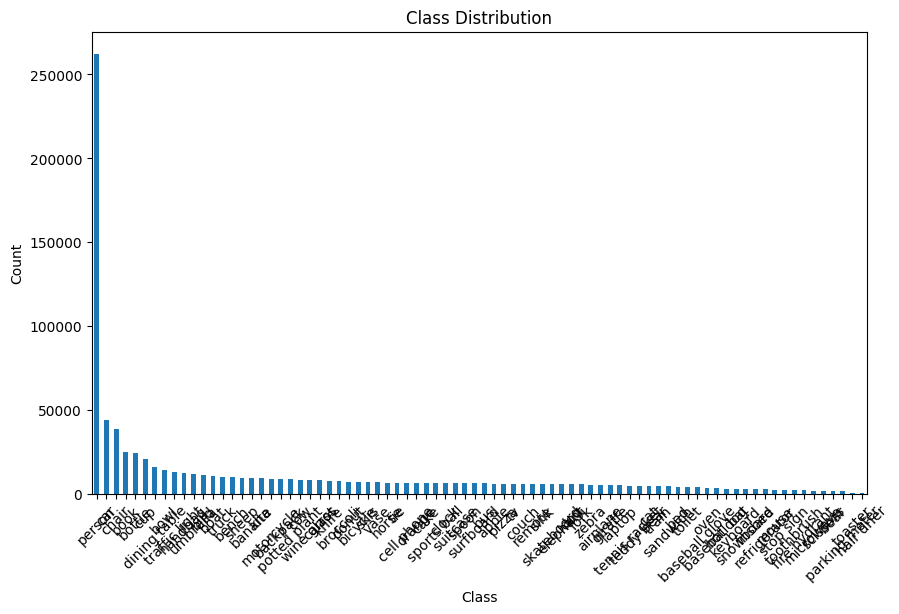

In [ ]:
# Plot class distribution
class_counts = annotations_df['category_id'].map(categories).value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

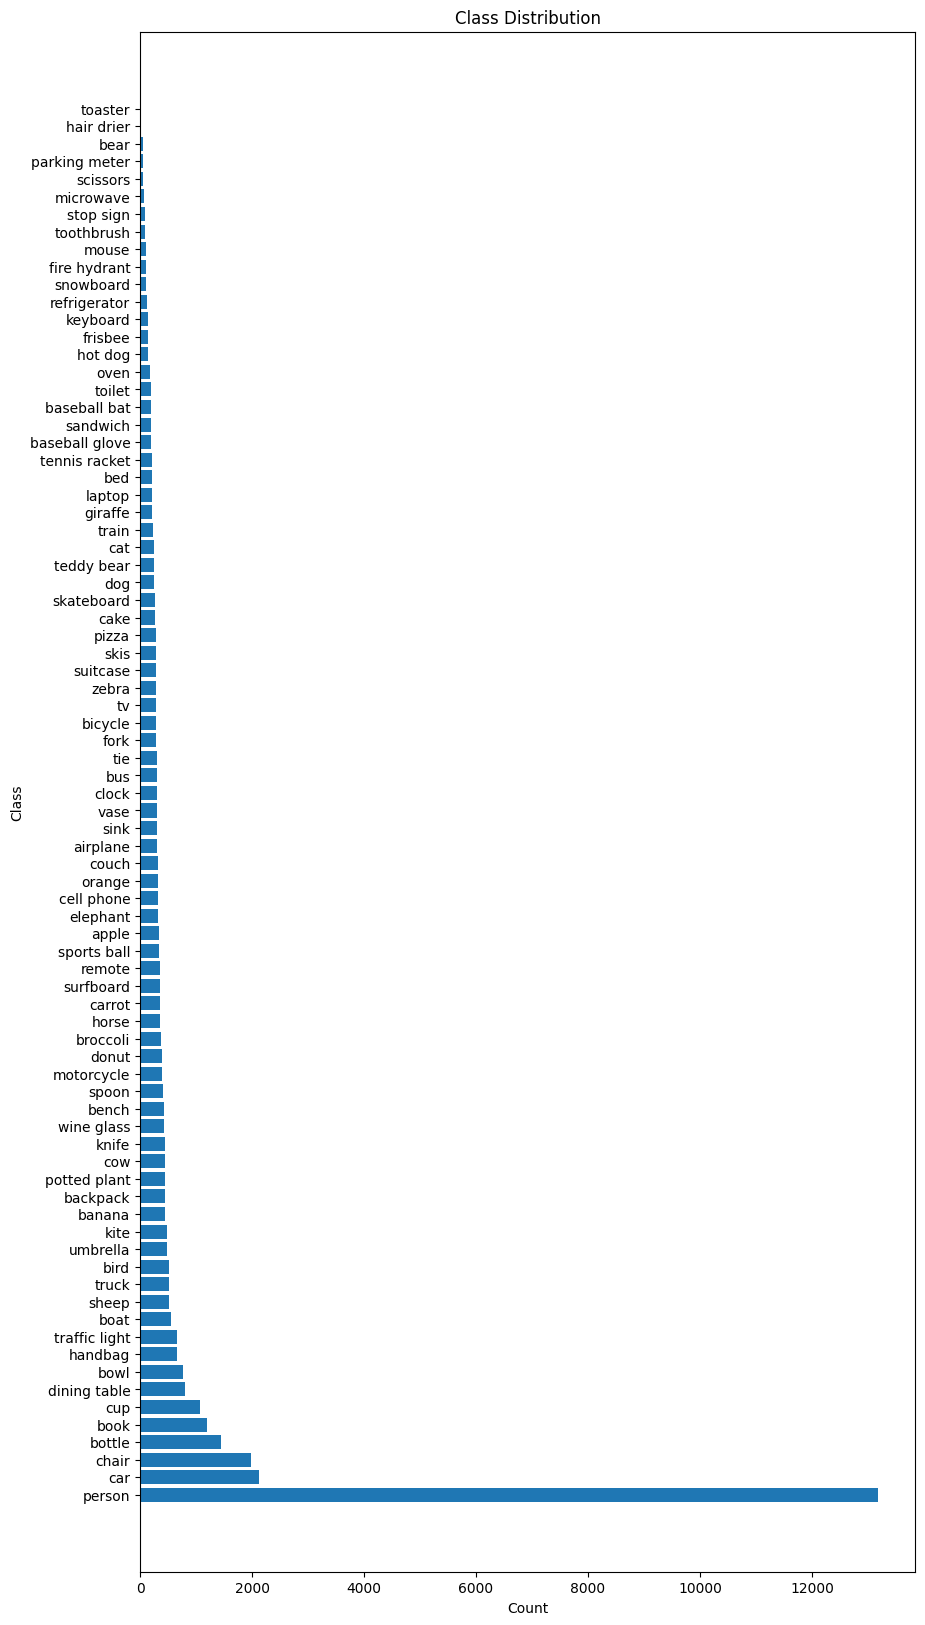

In [ ]:
# Extract relevant information from annotations(10% data)
categories = {category['id']: category['name'] for category in train_annotations_10_percent['categories']}
annotations_df = pd.DataFrame(train_annotations_10_percent['annotations'])
# Plot class distribution
class_counts = annotations_df['category_id'].map(categories).value_counts()
plt.figure(figsize=(10, 20))
plt.barh(class_counts.index, class_counts.values)  # Use barh for horizontal bars
plt.title('Class Distribution')
plt.ylabel('Class')  # Y-axis now represents classes
plt.xlabel('Count')
plt.show()

In [ ]:
# Basic statistics for class distribution
num_classes = len(class_counts)
total_annotations = annotations_df.shape[0]
class_counts_percentage = class_counts / total_annotations * 100

In [ ]:
print("\nClass Distribution Statistics:")
print(f"Number of Classes: {num_classes}")
print(f"Total Annotations: {total_annotations}")
print("Class Counts (Percentage of Total Annotations):")
print(class_counts_percentage)


Class Distribution Statistics:
Number of Classes: 80
Total Annotations: 860001
Class Counts (Percentage of Total Annotations):
person           30.519151
car               5.100808
chair             4.475692
book              2.873834
bottle            2.830462
                   ...    
scissors          0.172209
bear              0.150465
parking meter     0.149418
toaster           0.026163
hair drier        0.023023
Name: category_id, Length: 80, dtype: float64


In [ ]:
# Basic statistics for class distribution(10% data)
num_classes = len(class_counts)
total_annotations = annotations_df.shape[0]
class_counts_percentage = class_counts / total_annotations * 100
print("\nClass Distribution Statistics:")
print(f"Number of Classes: {num_classes}")
print(f"Total Annotations: {total_annotations}")
print("Class Counts (Percentage of Total Annotations):")
print(class_counts_percentage)


Class Distribution Statistics:
Number of Classes: 80
Total Annotations: 43458
Class Counts (Percentage of Total Annotations):
category_id
person           30.335036
car               4.878273
chair             4.544618
bottle            3.315845
book              2.733674
                   ...    
scissors          0.138064
parking meter     0.126559
bear              0.121957
hair drier        0.023011
toaster           0.023011
Name: count, Length: 80, dtype: float64


# Display sample images with bounding boxes

In [ ]:
def display_samples(image_dir, annotations, num_samples=5):
    sample_images = np.random.choice(annotations['images'], num_samples)

    plt.figure(figsize=(15, 8))
    for i, image_info in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = Image.open(image_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image ID: {image_info['id']}")
        # Add bounding boxes
        for annotation in annotations['annotations']:
            if annotation['image_id'] == image_info['id']:
                bbox = annotation['bbox']
                plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none'))

    plt.show()

Sample images from the training set:


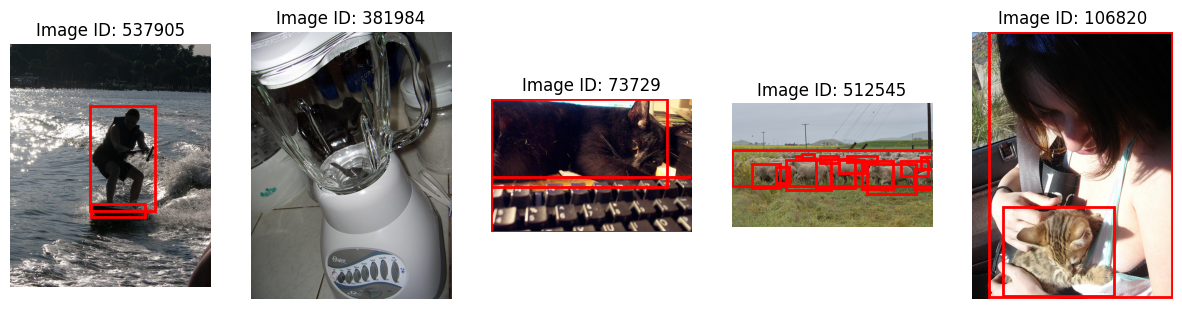

In [ ]:
# Display sample images with bounding boxes from the training set
print("Sample images from the training set:")
display_samples(train_image_dir, train_annotations)

Sample images from the training set:


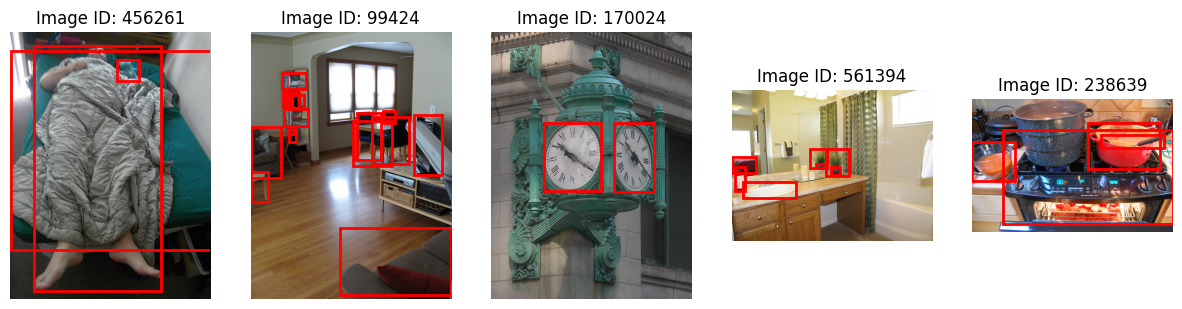

In [ ]:
# Display sample images with bounding boxes from the training set
print("Sample images from the training set:")
display_samples(train_image_dir, train_annotations)

Sample images from the validation set:


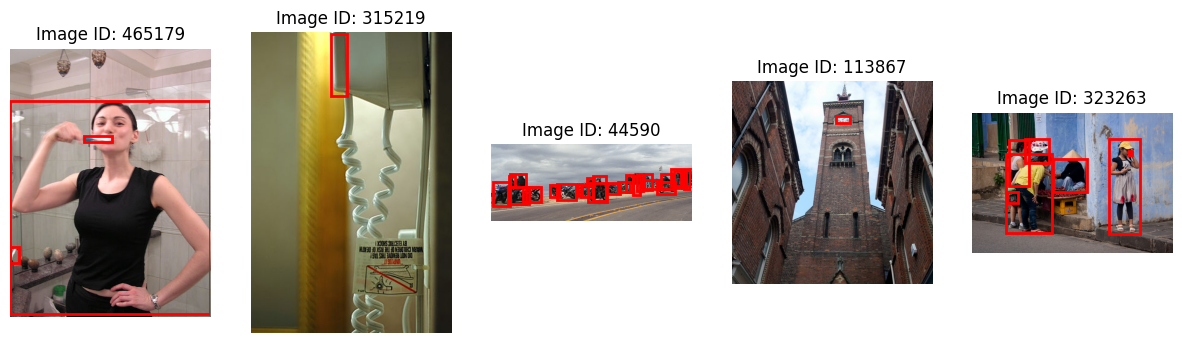

In [ ]:
# Display sample images with bounding boxes from the validation set
print("Sample images from the validation set:")
display_samples(val_image_dir, val_annotations)

Sample images from the validation set:


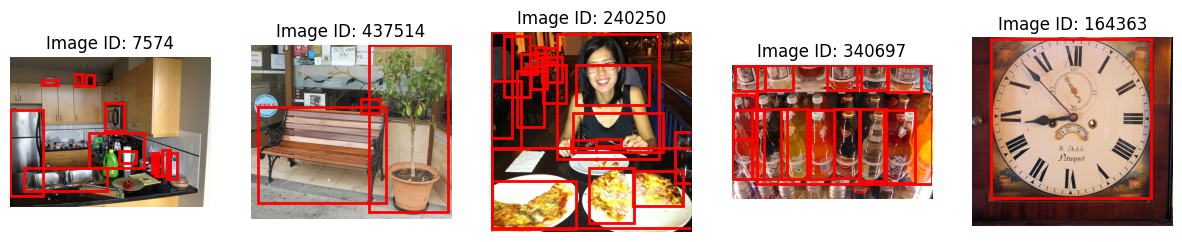

In [ ]:
# Display sample images with bounding boxes from the validation set
print("Sample images from the validation set:")
display_samples(val_image_dir, val_annotations)

# Script to Subset Validation Annotations and Training Annotations

In [ ]:
import os

def filter_label_files(images_dir, labels_dir):
    """Filters out text files in the labels directory that don't have corresponding image files.

    Args:
        images_dir (str): Path to the images directory.
        labels_dir (str): Path to the labels directory.
    """

    image_filenames = set(os.listdir(images_dir))  # Get all image filenames

    for label_filename in os.listdir(labels_dir):  # Iterate through label files
        base_filename, _ = os.path.splitext(label_filename)  # Remove ".txt" extension

        if base_filename not in image_filenames:
            # No corresponding image found
            label_path = os.path.join(labels_dir, label_filename)
            os.remove(label_path)  # Delete the label file
            # print(f"Removed unmatched label file: {label_path}")

In [ ]:
# Example usage:
images_train_dir = "/content/drive/MyDrive/subset_coco_final/dataset/images/train"
labels_train_dir = "/content/drive/MyDrive/subset_coco_final/dataset/labels/train"
images_val_dir = "/content/drive/MyDrive/subset_coco_final/dataset/images/val"
labels_val_dir = "/content/drive/MyDrive/subset_coco_final/dataset/labels/val"

filter_label_files(images_train_dir, labels_train_dir)
filter_label_files(images_val_dir, labels_val_dir)

In [ ]:
# Load the original COCO validation annotations
with open('/content/drive/MyDrive/subset_coco_10_percent/annotations/instances_val2017.json') as f:
    data = json.load(f)

In [ ]:
# our subset validation images directory
subset_dir = '/content/drive/MyDrive/subset_coco_10_percent/val2017'
subset_filenames = set(os.listdir(subset_dir))

In [ ]:
# Filter validation images and annotations
filtered_images = [img for img in data['images'] if img['file_name'] in subset_filenames]
filtered_img_ids = set(img['id'] for img in filtered_images)
filtered_annotations = [ann for ann in data['annotations'] if ann['image_id'] in filtered_img_ids]

# Create new dictionary with filtered data
subset_data = {
    "info": data["info"],
    "licenses": data["licenses"],
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": data["categories"]
}

# Save the subsetted annotations to a new file
subset_ann_file = '/content/drive/MyDrive/subset_coco_10_percent/annotations/instances_val2017_subset.json'
with open(subset_ann_file, 'w') as f:
    json.dump(subset_data, f)

print("Subsetted validation annotations saved to:", subset_ann_file)

Subsetted validation annotations saved to: /content/drive/MyDrive/subset_coco_10_percent/annotations/instances_val2017_subset.json


In [ ]:
# Load the original COCO training annotations
with open('/content/drive/MyDrive/subset_coco_10_percent/annotations/instances_train2017.json') as f:
    data = json.load(f)

In [ ]:
# our subset training images directory
subset_dir = '/content/drive/MyDrive/subset_coco_10_percent/train2017'
subset_filenames = set(os.listdir(subset_dir))

In [ ]:
# Filter training images and annotations
filtered_images = [img for img in data['images'] if img['file_name'] in subset_filenames]
filtered_img_ids = set(img['id'] for img in filtered_images)
filtered_annotations = [ann for ann in data['annotations'] if ann['image_id'] in filtered_img_ids]

# Create new dictionary with filtered data
subset_data = {
    "info": data["info"],
    "licenses": data["licenses"],
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": data["categories"]
}

# Save the subsetted annotations to a new file
subset_ann_file = '/content/drive/MyDrive/subset_coco_10_percent/annotations/instances_train2017_subset.json'
with open(subset_ann_file, 'w') as f:
    json.dump(subset_data, f)

print("Subsetted training annotations saved to:", subset_ann_file)

Subsetted training annotations saved to: /content/drive/MyDrive/subset_coco_10_percent/annotations/instances_train2017_subset.json


In [ ]:
len(subset_filenames)

5922

##Implement or Adapt a Data Loader

In [ ]:
from pycocotools.coco import COCO

In [ ]:
class CocoDetectionSubset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transform=None):
            self.root = root
            self.coco = COCO(annotation)
            self.transform = transform

            # Make sure to check the correct subset directory
            available_images = set(os.listdir(root))  # This should match the folder you're checking (train2017 or val2017)

            self.ids = [img_id for img_id in self.coco.imgs
                        if self.coco.loadImgs(img_id)[0]['file_name'] in available_images]

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        # Processing annotations to create the 'target' dict
        # Initialize containers for bounding boxes and labels
        boxes = []
        labels = []
        for ann in coco_annotation:
            # The COCO format of bounding box is [x, y, width, height]
            boxes.append(ann['bbox'])
            labels.append(ann['category_id'])

        # Convert boxes and labels into a PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Convert COCO bbox format to [x_min, y_min, x_max, y_max]
        boxes[:, 2:] += boxes[:, :2]
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transform:
            img, target = self.transform(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

### YOLOv8 Specific Transformations
This code defines the `YOLOv8Transforms` class, responsible for applying the necessary transformations to our dataset images before training with YOLOv8. It includes resizing the images to 640x640 pixels, converting them to PyTorch tensors, and normalizing them with the standard ImageNet mean and standard deviation values. These steps are crucial for preparing the images in a way that matches the expected input format for YOLOv8 models, optimizing the model's ability to learn from our dataset.

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter
from torchvision.transforms.functional import to_tensor, normalize

In [ ]:
class YOLOv8Transforms(object):
    def __init__(self, augment=True):
        # Base transformations
        self.base_transforms = Compose([
            Resize((640, 640)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Augmentations
        self.augmentations = Compose([
            RandomHorizontalFlip(p=0.5),
            ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        ]) if augment else None

    def __call__(self, image, target):
        if self.augmentations:
            image = self.augmentations(image)

        image = self.base_transforms(image)
        return image, target

### Integrating Transformations into Dataset Loader
Here, we initialize our COCO dataset subclass, `CocoDetectionSubset`, with the root directory for our images, the path to the annotation file, and the transformation class we defined above, `YOLOv8Transforms`. This setup ensures that all images fed into the YOLOv8 model undergo the necessary preprocessing steps (resizing, tensor conversion, normalization) as part of the data loading process.

In [ ]:
dataset = CocoDetectionSubset(root='/content/drive/MyDrive/subset_coco_10_percent/train2017',
                        annotation='/content/drive/MyDrive/subset_coco_10_percent/annotations/instances_train2017_subset.json',
                        transform=YOLOv8Transforms())

loading annotations into memory...
Done (t=0.96s)
creating index...
index created!


In [ ]:
print(f'Dataset size: {len(dataset)}')

Dataset size: 5922


In [ ]:
img, target = dataset[56]

In [ ]:
print(img.size(), target)

torch.Size([3, 640, 640]) {'boxes': tensor([[ 48.2900,   0.9700, 639.3600, 467.4400],
        [529.6200,   2.1600, 640.0000, 121.8900]]), 'labels': tensor([18,  1])}


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataset = CocoDetectionSubset(
    root='/content/drive/MyDrive/subset_coco_10_percent/train2017',
    annotation='/content/drive/MyDrive/subset_coco_10_percent/annotations/instances_train2017_subset.json',
    transform=YOLOv8Transforms(augment=True)
)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


In [ ]:
val_dataset = CocoDetectionSubset(
    root='/content/drive/MyDrive/subset_coco_10_percent/val2017',
    annotation='/content/drive/MyDrive/subset_coco_10_percent/annotations/instances_val2017_subset.json',
    transform=YOLOv8Transforms(augment=False)  # Usually, we don't apply augmentation to the validation set
)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [ ]:
def collate_fn(batch):
    """
    Custom collate_fn to handle batching of images where each image
    might have a different number of objects (and hence bounding boxes).

    Args:
        batch: A list of samples generated by CocoDetectionSubset.

    Returns:
        A tuple containing:
            - a tensor batch of images,
            - a list of dictionaries with keys 'boxes' and 'labels' for targets.
    """
    images = [item[0] for item in batch]  # Extract images
    targets = [item[1] for item in batch]  # Extract targets

    images = torch.stack(images, dim=0)

    return images, targets

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

In [ ]:
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# Trying out the ultralytics version to train the model and predict the images

In [ ]:
from ultralytics import YOLO

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_params = {
    "data": "/content/drive/MyDrive/subset_coco_10_percent/coco.yaml",
    "epochs": 1,  # Starting point,
    "imgsz": 640,
}

In [ ]:
model = YOLO('yolov8n.pt',verbose=True)

100%|██████████| 6.23M/6.23M [00:00<00:00, 101MB/s]


In [ ]:
model.info(detailed=True, verbose=True)

In [ ]:
help(model)

In [ ]:
from ultralytics.data.converter import convert_coco

convert_coco(labels_dir='/content/drive/MyDrive/subset_coco_10_percent/annotations/tv', save_dir='/content/drive/MyDrive/subset_coco_10_percent/dataset')

Annotations /content/drive/.shortcut-targets-by-id/1k77dd4S1oi1ZnRsr8lZJOmFqsuWhMYRZ/subset_coco_10_percent/annotations/tv/instances_train2017.json: 100%|██████████| 5872/5872 [00:30<00:00, 193.34it/s]
Annotations /content/drive/.shortcut-targets-by-id/1k77dd4S1oi1ZnRsr8lZJOmFqsuWhMYRZ/subset_coco_10_percent/annotations/tv/instances_val2017.json: 100%|██████████| 991/991 [00:05<00:00, 194.90it/s]

COCO data converted successfully.
Results saved to /content/drive/.shortcut-targets-by-id/1k77dd4S1oi1ZnRsr8lZJOmFqsuWhMYRZ/subset_coco_10_percent/dataset2


In [ ]:
!cat {'/content/datasets/coco.yaml'}

In [ ]:
from ultralytics import settings

# Update a setting
settings.update({'datasets_dir': '/content/drive/MyDrive/subset_coco_10_percent/dataset/'})

In [ ]:
!cat {'/root/.config/Ultralytics/settings.yaml'}

In [ ]:
help(model)

Help on YOLO in module ultralytics.models.yolo.model object:

class YOLO(ultralytics.engine.model.Model)
 |  YOLO(model='yolov8n.pt', task=None, verbose=False)
 |  
 |  YOLO (You Only Look Once) object detection model.
 |  
 |  Method resolution order:
 |      YOLO
 |      ultralytics.engine.model.Model
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model='yolov8n.pt', task=None, verbose=False)
 |      Initialize YOLO model, switching to YOLOWorld if model filename contains '-world'.
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  task_map
 |      Map head to model, trainer, validator, and predictor classes.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {}
 |  
 |  ----------------------------------------------------------------------


In [ ]:
results = model.train(data='/datasets/coco.yaml', epochs=100, imgsz=640,save_dir='/sri_runs')

Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/datasets/coco.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /datasets/labels/train.cache... 588 images, 4 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /datasets/labels/val.cache... 133 images, 1 backgrounds, 1 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]

val: WARNING ⚠️ /datasets/images/val/000000416269.jpg: ignoring corrupt image/label: image file is truncated (10 bytes not processed)


Plotting labels to runs/detect/train20/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train20
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.63G      1.183       1.41      1.241        239        640: 100%|██████████| 37/37 [00:08<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]

                   all        134       1044      0.698      0.484      0.571      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.27G      1.143      1.287      1.218        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

                   all        134       1044      0.574       0.52      0.555       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.04G      1.142      1.267      1.217        209        640: 100%|██████████| 37/37 [00:04<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all        134       1044      0.606      0.501      0.544        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.93G       1.13      1.238      1.203        162        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]

                   all        134       1044      0.559      0.509      0.533      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.08G      1.127       1.22      1.195        121        640: 100%|██████████| 37/37 [00:04<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        134       1044        0.6      0.477      0.538      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.94G      1.098      1.214      1.189        180        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

                   all        134       1044      0.637      0.461      0.527      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.03G      1.086      1.169      1.175        146        640: 100%|██████████| 37/37 [00:04<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

                   all        134       1044      0.585      0.468      0.516      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.93G        1.1      1.156      1.186        262        640: 100%|██████████| 37/37 [00:04<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

                   all        134       1044       0.57      0.457      0.512      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.06G      1.072      1.153      1.181        197        640: 100%|██████████| 37/37 [00:04<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]

                   all        134       1044      0.594      0.439      0.509      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.23G      1.073      1.101      1.154        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

                   all        134       1044      0.646      0.421      0.516      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.85G      1.079      1.119      1.161        247        640: 100%|██████████| 37/37 [00:04<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

                   all        134       1044      0.549      0.458       0.49      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.21G      1.049      1.059      1.141        194        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

                   all        134       1044      0.577      0.426      0.485      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.01G      1.048      1.051      1.146        244        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

                   all        134       1044      0.635      0.429      0.496      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.52G       1.03      1.073      1.155        222        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]

                   all        134       1044      0.615      0.449      0.498      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.98G      1.046      1.023      1.141        194        640: 100%|██████████| 37/37 [00:04<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        134       1044      0.731      0.398      0.499      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.21G      1.065      1.031       1.15        191        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        134       1044      0.612      0.437      0.491      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.33G      1.032      1.033      1.146        314        640: 100%|██████████| 37/37 [00:04<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

                   all        134       1044      0.612      0.429      0.486      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.09G      1.035      1.027      1.148        152        640: 100%|██████████| 37/37 [00:04<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

                   all        134       1044      0.608      0.425      0.485      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.15G      1.018     0.9925      1.129        188        640: 100%|██████████| 37/37 [00:04<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

                   all        134       1044      0.692      0.403      0.487       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.96G      1.021      1.011      1.127        238        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

                   all        134       1044        0.6      0.439      0.483      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.03G      1.014      1.012      1.143        201        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]

                   all        134       1044      0.633      0.433      0.491      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.02G     0.9999     0.9782      1.117        239        640: 100%|██████████| 37/37 [00:04<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

                   all        134       1044      0.628      0.429      0.498      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.16G      1.027     0.9699      1.123        136        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

                   all        134       1044      0.555      0.465      0.498      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.32G      1.009     0.9735      1.125        243        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

                   all        134       1044      0.586       0.42      0.479      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.23G      1.008     0.9584      1.125        197        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        134       1044      0.556      0.447      0.479      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.07G      1.015     0.9573      1.117        184        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

                   all        134       1044      0.609      0.444      0.488      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.11G      1.015     0.9724      1.132        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

                   all        134       1044      0.555       0.47        0.5      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.92G     0.9988     0.9404      1.124        206        640: 100%|██████████| 37/37 [00:04<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

                   all        134       1044      0.581      0.451      0.509       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.09G     0.9776     0.9262      1.113        269        640: 100%|██████████| 37/37 [00:04<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        134       1044      0.568      0.447      0.503       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.99G      0.983     0.9266      1.108        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.71it/s]

                   all        134       1044       0.63      0.421      0.502      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.22G       1.02     0.9621      1.128        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]

                   all        134       1044      0.632      0.422      0.487      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.07G     0.9824     0.9206      1.112        169        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

                   all        134       1044      0.658      0.386      0.491      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.31G     0.9773     0.9247      1.111        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

                   all        134       1044      0.568      0.421      0.493      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.08G     0.9663     0.9083      1.104        211        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        134       1044      0.632      0.402      0.478      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.04G     0.9509     0.8908      1.098        213        640: 100%|██████████| 37/37 [00:04<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

                   all        134       1044      0.583      0.455      0.482      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.32G     0.9746     0.8977      1.104        278        640: 100%|██████████| 37/37 [00:04<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        134       1044       0.57      0.455      0.495      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.25G     0.9746     0.8945        1.1        109        640: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all        134       1044      0.591      0.427      0.474      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.25G      0.975     0.8826      1.094        185        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        134       1044      0.595      0.429      0.482      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.24G     0.9645     0.8839       1.09        233        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

                   all        134       1044      0.571      0.426      0.489      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.11G     0.9606     0.8818      1.093        255        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

                   all        134       1044      0.585       0.43      0.494      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.29G     0.9555     0.8652      1.084        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]

                   all        134       1044      0.642      0.407      0.481      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.24G     0.9535     0.8681      1.091        185        640: 100%|██████████| 37/37 [00:04<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.92it/s]

                   all        134       1044      0.581      0.423      0.487      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.02G     0.9432     0.8708       1.09        162        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

                   all        134       1044      0.561      0.428      0.486      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.09G     0.9593     0.8664       1.09        142        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

                   all        134       1044       0.55      0.428       0.49      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.93G     0.9301     0.8455      1.083        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

                   all        134       1044      0.596      0.429      0.475      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.15G     0.9421     0.8611      1.083        206        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

                   all        134       1044      0.557      0.426      0.467      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.16G      0.958     0.8606      1.085        183        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]

                   all        134       1044       0.57      0.431      0.473      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.46G     0.9544     0.8607      1.093        186        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

                   all        134       1044      0.582      0.435      0.475       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.05G      0.948      0.857      1.093        264        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        134       1044      0.529      0.451      0.489      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.19G     0.9232     0.8405      1.088        144        640: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

                   all        134       1044      0.513      0.443      0.484      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.31G     0.9211     0.8302      1.086        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all        134       1044       0.64      0.419      0.473      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.96G     0.9318     0.8295       1.08        227        640: 100%|██████████| 37/37 [00:04<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

                   all        134       1044      0.587      0.414      0.465      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.08G     0.9338     0.8463      1.078        257        640: 100%|██████████| 37/37 [00:04<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        134       1044      0.595      0.422      0.468      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       3.1G     0.9374     0.8203      1.076        176        640: 100%|██████████| 37/37 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all        134       1044      0.592      0.412       0.46      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.23G      0.926      0.828       1.07        215        640: 100%|██████████| 37/37 [00:04<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

                   all        134       1044      0.629      0.411       0.47      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         3G     0.9241     0.8289      1.085        150        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

                   all        134       1044      0.643      0.405      0.463      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.09G     0.9193      0.818      1.077        202        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

                   all        134       1044      0.556      0.431      0.465       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.92G     0.9068     0.8127      1.069        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        134       1044      0.551      0.446      0.464      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.09G     0.9287     0.8316      1.074        170        640: 100%|██████████| 37/37 [00:04<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

                   all        134       1044      0.541      0.439       0.47      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.14G     0.9099     0.8159      1.077        160        640: 100%|██████████| 37/37 [00:04<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        134       1044      0.555      0.436      0.467      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.08G     0.9244     0.8037      1.071        263        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        134       1044      0.612      0.422      0.478      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.91G     0.9186     0.8241      1.076        181        640: 100%|██████████| 37/37 [00:04<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

                   all        134       1044      0.652      0.411      0.478       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.94G     0.9204     0.8134      1.073        175        640: 100%|██████████| 37/37 [00:04<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        134       1044      0.584      0.416      0.473      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.09G     0.9219     0.8065      1.071        197        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.93it/s]

                   all        134       1044       0.59      0.408      0.473      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.06G        0.9      0.798      1.072        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        134       1044      0.626       0.39      0.473      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.92G     0.8899      0.796      1.069        297        640: 100%|██████████| 37/37 [00:04<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]

                   all        134       1044      0.583      0.423       0.48      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.5G     0.9026     0.8044      1.068        262        640: 100%|██████████| 37/37 [00:04<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]

                   all        134       1044      0.583      0.425      0.474      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.02G     0.9112     0.8017      1.064        178        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

                   all        134       1044      0.603      0.435      0.481      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.08G     0.8914     0.7837      1.059        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        134       1044      0.554      0.444      0.484      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.14G     0.9017     0.7717      1.064        187        640: 100%|██████████| 37/37 [00:04<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

                   all        134       1044      0.599      0.414      0.476      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.09G     0.9057     0.7898      1.068        243        640: 100%|██████████| 37/37 [00:04<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]

                   all        134       1044      0.623      0.415      0.483      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.94G     0.9036     0.7954       1.07        224        640: 100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        134       1044      0.573      0.422      0.484      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.1G      0.897     0.7734      1.055        214        640: 100%|██████████| 37/37 [00:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        134       1044      0.532      0.436      0.469      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.24G     0.8899     0.7782      1.063        170        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

                   all        134       1044       0.53      0.449      0.471      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.11G     0.8706     0.7702      1.054        160        640: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

                   all        134       1044      0.561      0.432      0.476      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.19G     0.8901     0.7944      1.066        170        640: 100%|██████████| 37/37 [00:04<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]

                   all        134       1044      0.571      0.422      0.475      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.13G     0.8903     0.7709       1.06        198        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

                   all        134       1044      0.538      0.436      0.476      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.07G      0.871     0.7646      1.055        137        640: 100%|██████████| 37/37 [00:04<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        134       1044      0.511      0.455      0.477      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.06G     0.8759     0.7703      1.056        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.04it/s]

                   all        134       1044      0.637      0.391      0.468      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.99G     0.8856     0.7693      1.054        153        640: 100%|██████████| 37/37 [00:04<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

                   all        134       1044       0.64      0.394       0.47      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.27G     0.8676     0.7571      1.049        221        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

                   all        134       1044      0.572      0.409      0.467      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.29G     0.8737     0.7634      1.062        201        640: 100%|██████████| 37/37 [00:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.16it/s]

                   all        134       1044      0.572      0.422      0.472      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.95G     0.8741     0.7449      1.056        183        640: 100%|██████████| 37/37 [00:04<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        134       1044      0.558      0.431       0.47      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.98G     0.8844     0.7535      1.046        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

                   all        134       1044      0.572      0.425       0.47      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.47G     0.8868     0.7635      1.055        202        640: 100%|██████████| 37/37 [00:04<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        134       1044      0.554      0.431       0.47       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       3.1G     0.8972     0.7693      1.051        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        134       1044      0.564      0.432      0.482      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.29G     0.8787     0.7641      1.053        283        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

                   all        134       1044      0.588      0.412      0.471      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.16G     0.8669     0.7537      1.054        124        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        134       1044      0.633        0.4      0.469      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.01G      0.875     0.7665       1.06        174        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        134       1044      0.609      0.411      0.467      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.94G     0.8805     0.7563      1.053        211        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]

                   all        134       1044      0.589      0.416       0.47      0.335


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.13G     0.9158     0.8071      1.053        124        640: 100%|██████████| 37/37 [00:06<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]

                   all        134       1044      0.521      0.426      0.455      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.92G       0.88     0.7467      1.041         84        640: 100%|██████████| 37/37 [00:04<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        134       1044       0.51      0.425       0.45      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.94G     0.8707     0.7223      1.033        116        640: 100%|██████████| 37/37 [00:04<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

                   all        134       1044      0.498      0.416      0.446      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.07G     0.8772     0.7383      1.035         98        640: 100%|██████████| 37/37 [00:04<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

                   all        134       1044      0.602      0.378       0.45       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.03G     0.8645     0.6975      1.025         88        640: 100%|██████████| 37/37 [00:04<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        134       1044      0.607      0.369      0.451      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.94G     0.8415     0.6813      1.025         87        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        134       1044      0.556      0.401      0.461       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.06G     0.8439     0.6974      1.026         82        640: 100%|██████████| 37/37 [00:04<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

                   all        134       1044      0.565      0.391      0.466      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.92G     0.8348     0.6747      1.024         60        640: 100%|██████████| 37/37 [00:04<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        134       1044      0.586      0.388       0.46      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.91G     0.8491     0.6794      1.022        129        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

                   all        134       1044      0.579      0.385      0.463      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.92G     0.8558     0.7024      1.017         74        640: 100%|██████████| 37/37 [00:04<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        134       1044      0.561      0.395      0.461      0.317



100 epochs completed in 0.163 hours.
Optimizer stripped from runs/detect/train20/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train20/weights/best.pt, 6.5MB

Validating runs/detect/train20/weights/best.pt...
Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


                   all        134       1044      0.688      0.487      0.571      0.422
                person        134        279      0.793      0.613      0.717      0.475
               bicycle        134         14      0.803      0.357      0.416      0.304
                   car        134         44      0.602      0.515      0.501      0.358
            motorcycle        134         10      0.646        0.3      0.422      0.314
              airplane        134          4      0.675       0.75       0.75      0.675
                   bus        134         11      0.954      0.636      0.755       0.64
                 train        134          4       0.88          1      0.995      0.858
                 truck        134          8      0.713        0.5      0.618      0.374
                  boat        134          3      0.805      0.667      0.913      0.388
         traffic light        134         13          0          0     0.0389     0.0145
          fire hydran

In [ ]:
results.results_dict # first run

{'metrics/precision(B)': 0.6168585180523758,
 'metrics/recall(B)': 0.49190083666102613,
 'metrics/mAP50(B)': 0.5615749192482368,
 'metrics/mAP50-95(B)': 0.4163706928408331,
 'fitness': 0.4308911154815735}

In [ ]:
results.results_dict # second run

{'metrics/precision(B)': 0.6876256613317803,
 'metrics/recall(B)': 0.48711422046160446,
 'metrics/mAP50(B)': 0.5712268329685565,
 'metrics/mAP50-95(B)': 0.4219773720864537,
 'fitness': 0.436902318174664}

In [ ]:
results.mean_results()

[0.6876256613317803,
 0.48711422046160446,
 0.5712268329685565,
 0.4219773720864537]

In [ ]:
results.speed

{'preprocess': 0.13969015719285652,
 'inference': 10.826383064042277,
 'loss': 0.0004732786719478778,
 'postprocess': 20.504705941499168}

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /datasets/labels/val.cache... 133 images, 1 backgrounds, 1 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]

val: WARNING ⚠️ /datasets/images/val/000000416269.jpg: ignoring corrupt image/label: image file is truncated (10 bytes not processed)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


                   all        134       1044      0.609      0.512      0.577      0.431
                person        134        279      0.723      0.638      0.704       0.47
               bicycle        134         14      0.631      0.357      0.461      0.309
                   car        134         44      0.527      0.523      0.501      0.363
            motorcycle        134         10      0.633        0.3       0.48      0.314
              airplane        134          4      0.624       0.75       0.75      0.675
                   bus        134         11      0.963      0.636      0.726      0.607
                 train        134          4      0.841          1      0.995      0.871
                 truck        134          8      0.548        0.5      0.618      0.354
                  boat        134          3          1      0.837      0.995      0.435
         traffic light        134         13          0          0     0.0383     0.0143
          fire hydran

array([    0.47034,      0.3089,     0.36306,     0.31379,     0.67483,     0.60715,     0.87096,     0.35362,     0.43534,    0.014341,       0.995,      0.7084,     0.43074,     0.30063,     0.31181,     0.84862,      0.5145,     0.71848,     0.43074,      0.5721,      0.7323,     0.43074,     0.79332,     0.92089,
           0.28025,     0.29214,    0.019382,     0.10185,     0.51223,      0.6965,     0.38674,      0.8955,     0.46311,      0.8955,     0.64564,     0.41029,       0.597,    0.091476,     0.34297,      0.2681,     0.46088,     0.31352,     0.21816,    0.075556,    0.038906,     0.65997,     0.13864,      0.6965,
            0.3481,           0,     0.25031,     0.27069,       0.995,     0.28052,     0.53258,     0.30987,     0.27191,     0.56834,    0.098794,     0.31399,     0.45123,     0.26653,     0.67114,      0.5256,     0.53334,     0.43543,     0.52732,    0.075312,    0.041725,     0.31841,     0.43074,     0.74643,
           0.41622,     0.25668,     0.5278

In [ ]:
metrics.results_dict # validation 100 epochs # second time

{'metrics/precision(B)': 0.6093631090945536,
 'metrics/recall(B)': 0.5117055548469874,
 'metrics/mAP50(B)': 0.5765728317941705,
 'metrics/mAP50-95(B)': 0.4307393584146457,
 'fitness': 0.4453227057525982}

In [ ]:
results = model.train(data='/datasets/coco.yaml', epochs=50, imgsz=640,save_dir='/sri_runs')

Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/datasets/coco.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train192223, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /datasets/labels/train.cache... 588 images, 4 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /datasets/labels/val.cache... 133 images, 1 backgrounds, 1 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]

val: WARNING ⚠️ /datasets/images/val/000000416269.jpg: ignoring corrupt image/label: image file is truncated (10 bytes not processed)


Plotting labels to runs/detect/train192223/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train192223
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.47G     0.9607     0.9405      1.095        239        640: 100%|██████████| 37/37 [00:07<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        134       1044      0.578      0.452      0.493      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.96G      0.974     0.9133      1.105        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]

                   all        134       1044      0.595      0.425      0.495      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.72G     0.9655     0.9046      1.107        209        640: 100%|██████████| 37/37 [00:04<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]

                   all        134       1044       0.56      0.467       0.49      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.61G     0.9588     0.9038      1.102        162        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

                   all        134       1044      0.581       0.44      0.487      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       4.8G     0.9728     0.9114      1.103        121        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        134       1044      0.571      0.458      0.503      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.58G     0.9458     0.9049      1.094        180        640: 100%|██████████| 37/37 [00:04<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all        134       1044      0.592      0.427      0.486      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.72G     0.9427     0.8853      1.087        146        640: 100%|██████████| 37/37 [00:04<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]

                   all        134       1044      0.614      0.427      0.483      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.61G     0.9454     0.8883      1.097        262        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]

                   all        134       1044      0.605      0.419      0.477      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.74G     0.9329     0.8807      1.099        197        640: 100%|██████████| 37/37 [00:04<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

                   all        134       1044      0.593      0.412      0.484      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.91G     0.9335     0.8537      1.078        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]

                   all        134       1044      0.564      0.451      0.475       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.53G     0.9429     0.8761      1.084        247        640: 100%|██████████| 37/37 [00:04<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        134       1044       0.55      0.457      0.481      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       4.9G     0.9215     0.8408      1.071        194        640: 100%|██████████| 37/37 [00:04<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.04it/s]

                   all        134       1044      0.577      0.421      0.466      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       4.7G      0.921     0.8467      1.074        244        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]

                   all        134       1044      0.639       0.39      0.475      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.21G       0.94     0.8902        1.1        222        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]

                   all        134       1044      0.638      0.382      0.471      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.66G     0.9902     0.9235      1.103        194        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]

                   all        134       1044      0.615      0.418      0.475      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.89G      1.013     0.9294      1.116        191        640: 100%|██████████| 37/37 [00:04<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

                   all        134       1044      0.674      0.391      0.481       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.01G     0.9847     0.9367      1.119        314        640: 100%|██████████| 37/37 [00:04<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]

                   all        134       1044      0.588      0.419      0.467      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.77G     0.9884     0.9456      1.119        152        640: 100%|██████████| 37/37 [00:04<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

                   all        134       1044      0.576      0.434      0.464      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.83G     0.9758     0.9018      1.104        188        640: 100%|██████████| 37/37 [00:04<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

                   all        134       1044      0.535      0.446      0.467      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.65G     0.9741     0.9285      1.103        238        640: 100%|██████████| 37/37 [00:04<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        134       1044       0.58       0.42      0.463      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       4.7G     0.9689     0.9298      1.113        201        640: 100%|██████████| 37/37 [00:04<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

                   all        134       1044      0.566      0.421      0.477      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.69G     0.9583     0.9012      1.092        239        640: 100%|██████████| 37/37 [00:04<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

                   all        134       1044      0.584      0.438      0.488      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.83G      0.986     0.8884      1.097        136        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.92it/s]

                   all        134       1044      0.542      0.454      0.483      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.99G     0.9691     0.9028      1.098        243        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

                   all        134       1044      0.566      0.428      0.478      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       4.9G     0.9613     0.8876      1.096        197        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.08it/s]

                   all        134       1044      0.476      0.465      0.472      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.74G     0.9839     0.8881      1.099        184        640: 100%|██████████| 37/37 [00:04<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        134       1044      0.531      0.437      0.484      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.78G     0.9776     0.9048      1.108        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

                   all        134       1044      0.568       0.43      0.487      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.58G     0.9556      0.868      1.098        206        640: 100%|██████████| 37/37 [00:04<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

                   all        134       1044      0.515      0.459      0.486      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.76G     0.9419     0.8664      1.091        269        640: 100%|██████████| 37/37 [00:04<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        134       1044      0.584      0.426       0.49      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.66G     0.9478     0.8613      1.088        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        134       1044      0.547      0.432      0.477       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.89G     0.9785     0.8909        1.1        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

                   all        134       1044      0.584       0.42       0.47      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.74G     0.9486     0.8582      1.093        169        640: 100%|██████████| 37/37 [00:04<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]

                   all        134       1044      0.622      0.411      0.475      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.98G      0.941     0.8601      1.092        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        134       1044      0.545      0.432      0.479      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.75G     0.9321     0.8459      1.086        211        640: 100%|██████████| 37/37 [00:04<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

                   all        134       1044      0.505      0.448      0.471      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.71G     0.9174     0.8345       1.08        213        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

                   all        134       1044      0.499      0.447      0.483      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.03G     0.9368      0.841      1.084        278        640: 100%|██████████| 37/37 [00:04<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        134       1044      0.513      0.457      0.486      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.92G     0.9418     0.8388      1.084        109        640: 100%|██████████| 37/37 [00:04<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        134       1044      0.516      0.453      0.485       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.92G     0.9419     0.8248      1.077        185        640: 100%|██████████| 37/37 [00:04<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]

                   all        134       1044      0.543      0.433      0.484      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.91G     0.9358     0.8313      1.075        233        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

                   all        134       1044      0.577      0.427       0.49      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.82G     0.9332     0.8303      1.081        255        640: 100%|██████████| 37/37 [00:04<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        134       1044      0.529      0.462      0.494      0.353


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.74G     0.9638     0.8825      1.079         85        640: 100%|██████████| 37/37 [00:06<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

                   all        134       1044      0.495      0.441      0.455      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.75G     0.9231     0.8017      1.063        129        640: 100%|██████████| 37/37 [00:04<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]

                   all        134       1044      0.561      0.392      0.462      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.61G     0.9059     0.7667      1.056         68        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        134       1044      0.558      0.425      0.474      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.62G     0.8951      0.744      1.046         99        640: 100%|██████████| 37/37 [00:04<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.92it/s]

                   all        134       1044      0.648      0.375      0.474      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.74G     0.8904     0.7324       1.05         95        640: 100%|██████████| 37/37 [00:04<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

                   all        134       1044      0.632      0.385      0.475      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.72G     0.8764     0.7308      1.035        127        640: 100%|██████████| 37/37 [00:04<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        134       1044      0.611      0.383       0.47      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       4.6G     0.8948     0.7329      1.045         97        640: 100%|██████████| 37/37 [00:04<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        134       1044      0.667      0.364      0.466      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.72G     0.8872     0.7277      1.036        145        640: 100%|██████████| 37/37 [00:03<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        134       1044      0.656      0.368      0.466      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.63G     0.8739     0.7097      1.032        126        640: 100%|██████████| 37/37 [00:04<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        134       1044      0.558      0.395      0.467      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.63G     0.8617     0.7136      1.035         99        640: 100%|██████████| 37/37 [00:04<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]

                   all        134       1044      0.657      0.367      0.467      0.335



50 epochs completed in 0.081 hours.
Optimizer stripped from runs/detect/train192223/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train192223/weights/best.pt, 6.5MB

Validating runs/detect/train192223/weights/best.pt...
Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


                   all        134       1044      0.571      0.458      0.503      0.358
                person        134        279      0.686      0.634      0.684      0.436
               bicycle        134         14      0.855      0.286      0.366      0.239
                   car        134         44      0.483      0.477      0.449      0.307
            motorcycle        134         10      0.518        0.4      0.463      0.256
              airplane        134          4      0.427       0.75      0.752      0.643
                   bus        134         11      0.852      0.527      0.661      0.577
                 train        134          4      0.709          1      0.995      0.698
                 truck        134          8       0.61      0.375      0.416      0.223
                  boat        134          3      0.937      0.333      0.527      0.241
         traffic light        134         13          0          0     0.0327    0.00892
          fire hydran

In [ ]:
results.results_dict

{'metrics/precision(B)': 0.5705340215325007,
 'metrics/recall(B)': 0.45814513433408166,
 'metrics/mAP50(B)': 0.5033163480216561,
 'metrics/mAP50-95(B)': 0.3576923469159253,
 'fitness': 0.37225474702649836}

In [ ]:
results.save_dir

PosixPath('runs/detect/train192223')

In [ ]:
results.speed

{'preprocess': 0.152285419293304,
 'inference': 7.453895326870591,
 'loss': 0.0006085011496472715,
 'postprocess': 22.623846780008346}

In [ ]:
results.class_result(0)

(0.6858077357486514,
 0.6337080280786795,
 0.6835384126842652,
 0.43606666570337255)

In [ ]:
results.confusion_matrix.plot(normalize=True, save_dir='/', names=(), on_plot=None)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
results.curves

['Precision-Recall(B)',
 'F1-Confidence(B)',
 'Precision-Confidence(B)',
 'Recall-Confidence(B)']

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /datasets/labels/val.cache... 133 images, 1 backgrounds, 1 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]

val: WARNING ⚠️ /datasets/images/val/000000416269.jpg: ignoring corrupt image/label: image file is truncated (10 bytes not processed)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


                   all        134       1044      0.674      0.404      0.494      0.353
                person        134        279      0.815       0.57      0.689      0.439
               bicycle        134         14      0.918      0.286      0.359      0.238
                   car        134         44      0.641      0.455      0.435      0.291
            motorcycle        134         10       0.55        0.3      0.437       0.24
              airplane        134          4       0.65       0.75      0.752      0.644
                   bus        134         11          1      0.536       0.64      0.543
                 train        134          4      0.744          1      0.995      0.698
                 truck        134          8      0.693      0.375      0.401      0.207
                  boat        134          3          1          0      0.512      0.296
         traffic light        134         13          0          0     0.0342    0.00994
          fire hydran

array([    0.43935,     0.23805,     0.29147,     0.24022,     0.64377,     0.54287,     0.69776,     0.20662,     0.29577,   0.0099434,       0.995,     0.56094,     0.35342,     0.31554,     0.17567,     0.75418,     0.42012,      0.5323,     0.35342,      0.3817,     0.63297,     0.35342,     0.74802,      0.8955,
           0.19425,     0.27526,   0.0066312,    0.034999,     0.37194,      0.6965,     0.21821,      0.8955,     0.48781,     0.26367,     0.55292,     0.41327,     0.23217,    0.061408,     0.36642,     0.25144,     0.37093,     0.25432,     0.23961,    0.067571,    0.012874,     0.59792,    0.098625,     0.23217,
           0.30045,           0,     0.17126,     0.22894,       0.995,      0.3288,     0.16248,     0.26549,     0.20635,     0.52652,    0.075386,     0.31208,     0.40114,     0.19034,     0.61396,     0.46387,     0.40846,     0.39918,     0.46568,     0.10886,    0.014365,     0.26084,     0.35342,     0.61272,
           0.34075,    0.087756,     0.3803

In [ ]:
metrics.results_dict # validation 50 epochs

{'metrics/precision(B)': 0.6743905632809605,
 'metrics/recall(B)': 0.403630528884507,
 'metrics/mAP50(B)': 0.49356282388205597,
 'metrics/mAP50-95(B)': 0.3534199980032484,
 'fitness': 0.3674342805911292}

In [ ]:
results = model.train(data='/datasets/coco.yaml', epochs=400, imgsz=640,save_dir='/sri_runs')

Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/datasets/coco.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train1922234, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

train: Scanning /datasets/labels/train.cache... 588 images, 4 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /datasets/labels/val.cache... 133 images, 1 backgrounds, 1 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]

val: WARNING ⚠️ /datasets/images/val/000000416269.jpg: ignoring corrupt image/label: image file is truncated (10 bytes not processed)


Plotting labels to runs/detect/train1922234/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train1922234
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      5.66G      2.814      4.683      2.422        239        640: 100%|██████████| 37/37 [00:07<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

                   all        134       1044   0.000973    0.00752    0.00161   0.000667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400      3.44G      2.675      4.472      2.331        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]

                   all        134       1044     0.0151    0.00297    0.00359    0.00137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400       3.2G      2.464      4.306      2.203        209        640: 100%|██████████| 37/37 [00:04<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]

                   all        134       1044     0.0601    0.00241    0.00535    0.00195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400      3.09G      2.268      4.149      2.058        162        640: 100%|██████████| 37/37 [00:04<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        134       1044     0.0671     0.0244     0.0426     0.0298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400      3.24G      2.134      3.955      1.948        121        640: 100%|██████████| 37/37 [00:04<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]

                   all        134       1044      0.101     0.0413     0.0664     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400      3.06G      2.022      3.905      1.886        180        640: 100%|██████████| 37/37 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]

                   all        134       1044      0.102     0.0674     0.0806      0.055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400       3.2G      1.934      3.707      1.807        146        640: 100%|██████████| 37/37 [00:04<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]

                   all        134       1044      0.131      0.104      0.109     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400      3.05G        1.9      3.587      1.783        262        640: 100%|██████████| 37/37 [00:04<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]

                   all        134       1044      0.123       0.14       0.12     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400      3.22G      1.868      3.511      1.769        197        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]

                   all        134       1044      0.103      0.161      0.123     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400      3.39G      1.802      3.363      1.689        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]

                   all        134       1044      0.134      0.191      0.151     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400      3.01G      1.816      3.279      1.699        247        640: 100%|██████████| 37/37 [00:04<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]

                   all        134       1044      0.112      0.213      0.156      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400      3.34G      1.764      3.136      1.662        194        640: 100%|██████████| 37/37 [00:04<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]

                   all        134       1044      0.294      0.193       0.16      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400      3.18G       1.75      3.061      1.655        244        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]

                   all        134       1044       0.39      0.164      0.166       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400      3.69G      1.717      3.035      1.653        222        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]

                   all        134       1044      0.559      0.134      0.182       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400      3.15G      1.712      2.885      1.623        194        640: 100%|██████████| 37/37 [00:04<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]

                   all        134       1044      0.524      0.141      0.183      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400      3.38G      1.711      2.821      1.612        191        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]

                   all        134       1044      0.621      0.136      0.189      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400      3.49G       1.69      2.869       1.62        314        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]

                   all        134       1044      0.522      0.157      0.203      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400      3.25G      1.679      2.761       1.61        152        640: 100%|██████████| 37/37 [00:04<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]

                   all        134       1044      0.555      0.165      0.206      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400      3.32G      1.654      2.696      1.589        188        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]

                   all        134       1044      0.509      0.191      0.218      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400      3.13G      1.645      2.694      1.591        238        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

                   all        134       1044       0.49      0.202      0.222      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400      3.17G      1.642      2.653      1.601        201        640: 100%|██████████| 37/37 [00:04<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        134       1044      0.511      0.203      0.231      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400      3.16G      1.597      2.535      1.543        239        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]

                   all        134       1044      0.451      0.214       0.23      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400       3.3G      1.621      2.498      1.543        136        640: 100%|██████████| 37/37 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

                   all        134       1044      0.439      0.212      0.235      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400      3.47G      1.604       2.48      1.549        243        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]

                   all        134       1044      0.459      0.218      0.239      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400      3.37G      1.586      2.455      1.539        197        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        134       1044      0.468      0.227      0.247      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400      3.22G      1.598      2.381       1.52        184        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]

                   all        134       1044      0.548      0.211      0.245      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400      3.25G      1.571       2.45      1.522        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]

                   all        134       1044      0.436       0.22      0.254      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400      3.06G      1.562      2.394      1.526        206        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]

                   all        134       1044      0.541      0.212      0.255       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400      3.24G      1.534       2.36      1.504        269        640: 100%|██████████| 37/37 [00:04<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]

                   all        134       1044      0.517      0.221      0.256       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400      3.13G      1.522       2.33      1.496        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]

                   all        134       1044      0.493      0.222      0.261       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400      3.37G      1.544      2.298      1.497        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]

                   all        134       1044      0.481      0.245      0.266      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400      3.21G      1.517      2.246      1.493        169        640: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]

                   all        134       1044      0.538      0.225      0.269      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400      3.45G      1.502      2.278      1.481        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]

                   all        134       1044      0.546      0.222      0.277      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400      3.23G      1.504      2.254      1.489        211        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]

                   all        134       1044      0.459       0.25       0.27      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400      3.19G      1.478      2.216      1.476        213        640: 100%|██████████| 37/37 [00:04<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]

                   all        134       1044      0.415      0.271      0.273      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400       3.5G      1.494      2.167      1.474        278        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]

                   all        134       1044      0.438      0.264      0.279       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400       3.4G       1.49      2.156      1.468        109        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]

                   all        134       1044      0.446      0.261      0.278      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400       3.4G      1.488      2.132      1.451        185        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]

                   all        134       1044      0.418      0.261      0.283      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400      3.43G       1.47      2.131      1.446        233        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]

                   all        134       1044      0.483      0.261      0.284      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400      3.29G      1.464      2.136      1.452        255        640: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

                   all        134       1044      0.534      0.234      0.274      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400      3.44G      1.439      2.099      1.421        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]

                   all        134       1044      0.457      0.276      0.286      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400      3.39G       1.43      2.078      1.429        185        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.93it/s]

                   all        134       1044      0.465      0.275      0.281      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400      3.21G      1.433      2.068      1.435        162        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]

                   all        134       1044      0.487      0.267       0.29      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400      3.23G      1.426      2.043      1.417        142        640: 100%|██████████| 37/37 [00:04<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.02it/s]

                   all        134       1044      0.458      0.274       0.29      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400      3.11G      1.406      2.048      1.421        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]

                   all        134       1044      0.417      0.295      0.297       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400       3.3G      1.424      2.027      1.413        206        640: 100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]

                   all        134       1044      0.432      0.287      0.294       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400      3.31G      1.413      1.977      1.402        183        640: 100%|██████████| 37/37 [00:04<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.00it/s]

                   all        134       1044      0.494      0.265      0.293      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400      3.64G      1.422      2.014      1.411        186        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]

                   all        134       1044      0.489      0.262      0.287      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400       3.2G      1.413      2.009      1.415        264        640: 100%|██████████| 37/37 [00:04<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.96it/s]

                   all        134       1044      0.373      0.287      0.291      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400      3.33G      1.385       1.99      1.411        144        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]

                   all        134       1044      0.434      0.291        0.3      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400      3.45G      1.356      1.979      1.392        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]

                   all        134       1044      0.411      0.291      0.289      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400      3.15G      1.388      1.929      1.399        227        640: 100%|██████████| 37/37 [00:04<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]

                   all        134       1044      0.447       0.31      0.296      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400      3.22G      1.386      1.934      1.388        257        640: 100%|██████████| 37/37 [00:04<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.05it/s]

                   all        134       1044      0.435      0.295      0.289      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400      3.29G      1.378      1.864      1.376        176        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]

                   all        134       1044       0.39      0.288        0.3      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400      3.37G      1.362      1.887       1.37        215        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]

                   all        134       1044      0.422      0.292      0.294      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400      3.15G      1.361      1.915       1.39        150        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.01it/s]

                   all        134       1044      0.409      0.302      0.305      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400      3.19G      1.348      1.855      1.373        202        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]

                   all        134       1044      0.387      0.306      0.302      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400      3.11G      1.342      1.835      1.365        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]

                   all        134       1044      0.381      0.321      0.306      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400      3.23G      1.359       1.89      1.377        170        640: 100%|██████████| 37/37 [00:04<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.03it/s]

                   all        134       1044      0.413      0.302       0.31      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400      3.28G      1.338      1.875      1.372        160        640: 100%|██████████| 37/37 [00:04<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]

                   all        134       1044      0.371      0.298      0.298      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400      3.23G      1.341      1.804      1.357        263        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.03it/s]

                   all        134       1044       0.42        0.3      0.297      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400       3.1G      1.341      1.841       1.37        181        640: 100%|██████████| 37/37 [00:04<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

                   all        134       1044      0.394      0.304      0.294      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400      3.08G      1.327      1.834      1.357        175        640: 100%|██████████| 37/37 [00:04<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.05it/s]

                   all        134       1044      0.414       0.29       0.31      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400      3.19G      1.334       1.79      1.351        197        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

                   all        134       1044      0.382      0.282      0.307      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400       3.2G      1.312      1.795      1.358        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.04it/s]

                   all        134       1044      0.385      0.311      0.301      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/400      3.11G      1.301      1.786      1.353        297        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]

                   all        134       1044      0.432      0.297      0.306      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/400      3.65G      1.338        1.8      1.366        262        640: 100%|██████████| 37/37 [00:04<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]

                   all        134       1044      0.426      0.309       0.31      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/400      3.17G      1.321       1.76       1.34        178        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.00it/s]

                   all        134       1044      0.444      0.304      0.311      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/400      3.27G      1.287      1.732      1.331        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.19it/s]

                   all        134       1044      0.384      0.308      0.309      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/400      3.29G      1.295      1.726      1.328        187        640: 100%|██████████| 37/37 [00:04<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.22it/s]

                   all        134       1044      0.441      0.301      0.315      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/400      3.24G       1.31       1.74      1.344        243        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]

                   all        134       1044      0.474      0.284      0.308      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/400      3.08G        1.3      1.745       1.34        224        640: 100%|██████████| 37/37 [00:04<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.09it/s]

                   all        134       1044      0.456      0.297      0.312      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/400      3.24G      1.288      1.699      1.315        214        640: 100%|██████████| 37/37 [00:04<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.33it/s]

                   all        134       1044      0.447      0.295      0.314        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/400      3.39G      1.302      1.739      1.338        170        640: 100%|██████████| 37/37 [00:04<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]

                   all        134       1044      0.395      0.301      0.301      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/400      3.25G       1.25      1.669      1.315        160        640: 100%|██████████| 37/37 [00:04<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.09it/s]

                   all        134       1044      0.415      0.308      0.307      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/400      3.33G      1.274      1.704      1.328        170        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]

                   all        134       1044      0.391      0.312      0.314      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/400      3.28G      1.273      1.677      1.318        198        640: 100%|██████████| 37/37 [00:04<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]

                   all        134       1044      0.414      0.317      0.326      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/400      3.21G      1.262      1.682      1.319        137        640: 100%|██████████| 37/37 [00:04<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]

                   all        134       1044      0.382      0.317      0.318      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/400       3.2G      1.258      1.666      1.312        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]

                   all        134       1044      0.405      0.296       0.31      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/400      3.14G      1.271      1.671      1.308        153        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]

                   all        134       1044      0.398      0.297      0.318      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/400      3.42G      1.242      1.632      1.297        221        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.12it/s]

                   all        134       1044      0.446        0.3      0.324      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/400      3.44G      1.258      1.665      1.319        201        640: 100%|██████████| 37/37 [00:04<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]

                   all        134       1044      0.463      0.291      0.315      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/400      3.09G      1.241      1.627      1.303        183        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]

                   all        134       1044      0.473      0.288      0.317      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/400      3.12G      1.258       1.61      1.297        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]

                   all        134       1044      0.478      0.286      0.314      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/400      3.62G      1.264      1.635      1.303        202        640: 100%|██████████| 37/37 [00:04<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]

                   all        134       1044      0.457      0.296      0.312      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/400      3.25G      1.275      1.634      1.301        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.24it/s]

                   all        134       1044      0.401        0.3      0.311      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/400      3.44G      1.234      1.624      1.289        283        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.23it/s]

                   all        134       1044      0.377      0.319      0.322      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/400      3.31G      1.253      1.625      1.304        124        640: 100%|██████████| 37/37 [00:04<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.05it/s]

                   all        134       1044       0.44      0.315      0.325      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/400      3.15G      1.238      1.621      1.305        174        640: 100%|██████████| 37/37 [00:04<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.04it/s]

                   all        134       1044      0.441      0.293      0.314      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/400      3.09G      1.254       1.61      1.302        211        640: 100%|██████████| 37/37 [00:04<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]

                   all        134       1044      0.446       0.29       0.32      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/400      3.37G      1.243      1.599      1.295        221        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.20it/s]

                   all        134       1044      0.384      0.295      0.321      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/400      3.14G      1.243      1.569      1.287        154        640: 100%|██████████| 37/37 [00:04<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.04it/s]

                   all        134       1044      0.418      0.303      0.326      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/400      3.29G      1.234       1.59      1.286        244        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

                   all        134       1044      0.381      0.319      0.325      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/400      3.14G      1.231      1.551      1.278        147        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]

                   all        134       1044      0.523      0.276       0.32        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/400      3.22G      1.221       1.54      1.274        237        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]

                   all        134       1044      0.432      0.291      0.319      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/400      3.14G      1.243      1.609      1.293        230        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.44it/s]

                   all        134       1044      0.386      0.306      0.313      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/400      3.32G      1.236      1.573      1.283        196        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.24it/s]

                   all        134       1044      0.432      0.305      0.317      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/400      3.23G      1.227      1.554      1.294        241        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]

                   all        134       1044      0.405      0.312      0.316      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/400      3.14G       1.21      1.547      1.282        209        640: 100%|██████████| 37/37 [00:04<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

                   all        134       1044      0.402      0.307      0.319      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/400       3.1G      1.212      1.536      1.276        132        640: 100%|██████████| 37/37 [00:04<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]

                   all        134       1044      0.401      0.318      0.323      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/400      3.32G      1.213      1.564      1.279        150        640: 100%|██████████| 37/37 [00:04<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]

                   all        134       1044       0.39      0.325      0.317      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/400      3.27G        1.2      1.513       1.28        164        640: 100%|██████████| 37/37 [00:04<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]

                   all        134       1044      0.374      0.331      0.317      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/400      3.41G      1.225      1.522      1.274        284        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

                   all        134       1044      0.396      0.314       0.32      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/400      3.34G      1.231      1.541      1.278        196        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

                   all        134       1044      0.435      0.296      0.322      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/400      3.45G      1.207      1.501      1.267        225        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.32it/s]

                   all        134       1044      0.475      0.293      0.323      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/400      3.28G      1.179      1.483      1.261        208        640: 100%|██████████| 37/37 [00:04<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]

                   all        134       1044      0.517      0.264      0.322      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/400      3.28G      1.233      1.517      1.272        316        640: 100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]

                   all        134       1044      0.367      0.326      0.319      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/400      3.25G      1.206      1.492      1.262        198        640: 100%|██████████| 37/37 [00:04<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

                   all        134       1044      0.479      0.276      0.314        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/400      3.12G      1.202      1.501      1.277        164        640: 100%|██████████| 37/37 [00:04<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]

                   all        134       1044       0.41      0.299      0.315      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/400       3.1G      1.189      1.466      1.257        205        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]

                   all        134       1044      0.394      0.309      0.311      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/400      3.23G      1.191      1.497      1.262        191        640: 100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]

                   all        134       1044       0.38      0.304      0.313      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/400      3.12G      1.208      1.477      1.262        278        640: 100%|██████████| 37/37 [00:04<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]

                   all        134       1044      0.404      0.298      0.322      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/400      3.29G      1.207      1.454      1.249        147        640: 100%|██████████| 37/37 [00:04<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]

                   all        134       1044      0.409      0.301      0.319      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/400       3.3G      1.207        1.5      1.275        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

                   all        134       1044      0.386      0.312      0.322      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/400      3.38G      1.212      1.478      1.265        180        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.40it/s]

                   all        134       1044      0.445      0.292      0.337      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/400       3.3G      1.194       1.44      1.251        245        640: 100%|██████████| 37/37 [00:04<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.44it/s]

                   all        134       1044      0.427      0.278      0.321      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/400      3.33G      1.187      1.466      1.254        272        640: 100%|██████████| 37/37 [00:04<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

                   all        134       1044      0.393      0.319       0.32      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/400      3.37G      1.205      1.468      1.257        233        640: 100%|██████████| 37/37 [00:04<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]

                   all        134       1044      0.427       0.31      0.334      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/400      3.17G      1.192      1.449      1.254        204        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

                   all        134       1044      0.393      0.305      0.332       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/400      3.41G      1.191      1.428      1.247        178        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]

                   all        134       1044      0.428      0.311      0.338      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/400      3.57G      1.192      1.431      1.243        176        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

                   all        134       1044      0.421      0.314      0.333      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/400      3.12G      1.178      1.444      1.247        240        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]

                   all        134       1044      0.526       0.29      0.336      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/400       3.2G      1.157       1.43      1.243        186        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.12it/s]

                   all        134       1044      0.435      0.305      0.331      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/400       3.1G      1.161      1.387      1.228        202        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]

                   all        134       1044      0.446      0.307      0.329      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/400      3.12G      1.175       1.43      1.248        215        640: 100%|██████████| 37/37 [00:04<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]

                   all        134       1044      0.439      0.309      0.334      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/400      3.14G      1.178      1.421      1.242        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]

                   all        134       1044      0.444      0.302       0.33      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/400      3.53G       1.19      1.412      1.235        223        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]

                   all        134       1044      0.458      0.298      0.328      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/400      3.32G      1.184      1.432      1.246        176        640: 100%|██████████| 37/37 [00:04<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]

                   all        134       1044       0.49      0.293       0.33      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/400      3.09G       1.19      1.408       1.24        264        640: 100%|██████████| 37/37 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

                   all        134       1044      0.452      0.307      0.325      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/400      3.21G      1.171      1.392       1.24        185        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]

                   all        134       1044      0.569      0.268      0.325      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/400      3.02G      1.169      1.397      1.235        166        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.44it/s]

                   all        134       1044      0.488      0.305      0.334      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/400      3.23G      1.158      1.413      1.243        196        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

                   all        134       1044      0.461      0.295      0.326      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/400      3.29G      1.193      1.416      1.243        201        640: 100%|██████████| 37/37 [00:04<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]

                   all        134       1044      0.447      0.313      0.329      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/400      3.21G      1.162      1.395      1.244        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]

                   all        134       1044      0.367      0.323      0.323      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/400      3.11G      1.184      1.387      1.238        194        640: 100%|██████████| 37/37 [00:04<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.22it/s]

                   all        134       1044      0.452      0.307      0.318      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/400       3.2G      1.142      1.357      1.222        120        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]

                   all        134       1044      0.458      0.308      0.331      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/400      3.09G      1.131      1.365      1.224        153        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]

                   all        134       1044      0.407      0.331      0.333      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/400      3.45G      1.156      1.387      1.239        244        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.32it/s]

                   all        134       1044      0.434       0.33      0.331      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/400      3.49G      1.168      1.393      1.239        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

                   all        134       1044      0.426      0.326      0.332       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/400      3.21G      1.175      1.367      1.236        189        640: 100%|██████████| 37/37 [00:04<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

                   all        134       1044       0.46      0.317      0.337      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/400      3.41G      1.181      1.376      1.227        257        640: 100%|██████████| 37/37 [00:04<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]

                   all        134       1044       0.44       0.32      0.332      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/400      3.28G      1.167      1.375      1.234        225        640: 100%|██████████| 37/37 [00:04<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]

                   all        134       1044       0.47      0.298      0.332      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/400      3.23G      1.144      1.331      1.216        224        640: 100%|██████████| 37/37 [00:04<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]

                   all        134       1044      0.421      0.304      0.323      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/400      3.14G      1.141      1.351       1.22        214        640: 100%|██████████| 37/37 [00:04<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]

                   all        134       1044      0.612      0.261      0.331      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/400      3.32G      1.153      1.365      1.237        224        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]

                   all        134       1044      0.442      0.297      0.332      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/400      3.44G      1.127      1.347       1.22        181        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]

                   all        134       1044      0.384      0.323      0.333      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/400      3.31G      1.151      1.357      1.216        155        640: 100%|██████████| 37/37 [00:04<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]

                   all        134       1044      0.488      0.294      0.332      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/400      3.21G      1.145      1.353      1.224        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.91it/s]

                   all        134       1044      0.495      0.284      0.327       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/400      3.56G      1.155      1.371      1.225        129        640: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

                   all        134       1044       0.43      0.306      0.316      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/400      3.31G      1.124      1.334      1.219        170        640: 100%|██████████| 37/37 [00:04<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]

                   all        134       1044      0.415      0.305      0.331      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/400      2.99G      1.159      1.348      1.219        284        640: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]

                   all        134       1044      0.465      0.284      0.324      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/400      3.31G      1.161      1.348      1.226        192        640: 100%|██████████| 37/37 [00:04<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.71it/s]

                   all        134       1044      0.528      0.271      0.324       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/400      3.22G      1.138      1.336      1.216        123        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]

                   all        134       1044      0.434      0.294      0.327      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/400      3.26G      1.134      1.335      1.212        176        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]

                   all        134       1044      0.513      0.276      0.332      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/400      3.06G      1.146       1.34      1.224        133        640: 100%|██████████| 37/37 [00:04<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]

                   all        134       1044      0.409      0.307      0.326       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/400      3.11G      1.159      1.337      1.211        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]

                   all        134       1044      0.482      0.295      0.328      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/400      3.09G      1.147      1.359      1.224        202        640: 100%|██████████| 37/37 [00:04<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]

                   all        134       1044      0.488      0.302      0.333      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/400      3.11G      1.089      1.316      1.202        132        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

                   all        134       1044      0.425      0.295      0.332      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/400      3.25G      1.151      1.314      1.219        149        640: 100%|██████████| 37/37 [00:04<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]

                   all        134       1044      0.417      0.304      0.332      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/400      3.29G       1.13      1.293      1.207        204        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

                   all        134       1044      0.436      0.301       0.33      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/400      3.23G       1.13      1.285      1.211        184        640: 100%|██████████| 37/37 [00:04<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

                   all        134       1044       0.46      0.294      0.333      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/400      3.28G      1.094      1.258      1.181        268        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

                   all        134       1044      0.401      0.316      0.325      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/400      3.34G      1.126       1.31      1.206        222        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]

                   all        134       1044      0.415      0.303      0.325      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/400       3.2G      1.147      1.294      1.213        146        640: 100%|██████████| 37/37 [00:04<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

                   all        134       1044      0.437      0.315      0.332      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/400      3.13G      1.132      1.321      1.214        205        640: 100%|██████████| 37/37 [00:04<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

                   all        134       1044      0.472      0.299      0.323      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/400      3.15G      1.098      1.273      1.201        232        640: 100%|██████████| 37/37 [00:04<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

                   all        134       1044      0.418      0.316      0.336      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/400      3.01G      1.122      1.291      1.209        120        640: 100%|██████████| 37/37 [00:04<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

                   all        134       1044      0.523      0.286      0.334      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/400      3.39G      1.141      1.304      1.215        222        640: 100%|██████████| 37/37 [00:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]

                   all        134       1044      0.511      0.296      0.331      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/400      3.25G      1.119      1.282      1.199        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

                   all        134       1044      0.408      0.311      0.338      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/400      3.25G       1.13       1.31      1.214        269        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]

                   all        134       1044      0.511      0.293      0.342       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/400      3.28G      1.119       1.28      1.196        172        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

                   all        134       1044       0.47      0.307       0.34      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/400      3.53G      1.128      1.275      1.213        177        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.24it/s]

                   all        134       1044       0.39      0.317      0.338       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/400      3.44G      1.125      1.264      1.194        225        640: 100%|██████████| 37/37 [00:04<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]

                   all        134       1044      0.397      0.308      0.332      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/400      3.23G      1.098      1.285      1.194        285        640: 100%|██████████| 37/37 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]

                   all        134       1044       0.39      0.321      0.333      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/400      3.11G      1.106      1.262      1.194        192        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]

                   all        134       1044      0.415      0.315      0.332      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/400      3.21G      1.088      1.272       1.19        199        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]

                   all        134       1044       0.45      0.308      0.335      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/400      3.25G      1.078      1.245      1.189        191        640: 100%|██████████| 37/37 [00:04<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

                   all        134       1044      0.507      0.301      0.337       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/400      3.44G       1.14      1.277      1.199        224        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]

                   all        134       1044      0.428      0.309      0.336      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/400      3.28G      1.119      1.268      1.203        255        640: 100%|██████████| 37/37 [00:04<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]

                   all        134       1044      0.408      0.318      0.333      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/400      3.11G      1.092      1.261      1.206        148        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]

                   all        134       1044      0.429      0.317      0.331      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/400      3.35G      1.114      1.292      1.215        229        640: 100%|██████████| 37/37 [00:04<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

                   all        134       1044      0.418      0.316      0.333      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/400      3.21G        1.1      1.259      1.199        240        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]

                   all        134       1044      0.411      0.326      0.333      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/400      3.18G      1.105      1.295        1.2        185        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.64it/s]

                   all        134       1044      0.415       0.32      0.333      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/400       3.1G       1.11       1.26      1.197        193        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

                   all        134       1044      0.411      0.328      0.332      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/400      3.33G      1.098      1.256      1.195        175        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

                   all        134       1044      0.451      0.313      0.336      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/400      3.43G      1.109      1.266      1.202        220        640: 100%|██████████| 37/37 [00:04<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.64it/s]

                   all        134       1044      0.436      0.316      0.332      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/400      3.21G      1.104      1.289        1.2        132        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]

                   all        134       1044      0.483      0.303      0.333      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/400      3.25G      1.086       1.23      1.183        233        640: 100%|██████████| 37/37 [00:04<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

                   all        134       1044      0.455      0.318      0.337      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/400      3.34G      1.092      1.237      1.201        240        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.23it/s]

                   all        134       1044      0.409      0.309       0.33      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/400      3.23G      1.091       1.22      1.183        143        640: 100%|██████████| 37/37 [00:04<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        134       1044       0.44      0.312      0.336      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/400      3.33G      1.102      1.236      1.195        200        640: 100%|██████████| 37/37 [00:04<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

                   all        134       1044      0.465      0.303      0.333      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/400       3.2G      1.084      1.223      1.187        267        640: 100%|██████████| 37/37 [00:04<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

                   all        134       1044      0.423      0.311      0.331      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/400      3.34G      1.084       1.24      1.184        166        640: 100%|██████████| 37/37 [00:04<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]

                   all        134       1044       0.41       0.31      0.319      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/400      3.07G      1.109      1.241      1.192        187        640: 100%|██████████| 37/37 [00:04<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

                   all        134       1044       0.39      0.322      0.315      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/400       3.4G      1.114      1.227      1.188        282        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

                   all        134       1044      0.381      0.329      0.324      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/400      3.09G      1.092      1.227      1.194        116        640: 100%|██████████| 37/37 [00:04<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

                   all        134       1044       0.39      0.313      0.323      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/400      3.25G      1.087      1.218      1.183        245        640: 100%|██████████| 37/37 [00:04<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]

                   all        134       1044      0.394      0.326      0.328      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/400      3.46G      1.093      1.249      1.196        107        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

                   all        134       1044      0.405      0.313      0.324       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/400      3.01G      1.099      1.222       1.18        174        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

                   all        134       1044      0.435      0.311      0.328      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/400       3.1G      1.073      1.184      1.177        189        640: 100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.64it/s]

                   all        134       1044      0.447      0.304       0.33      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/400      3.41G      1.106      1.198      1.189        246        640: 100%|██████████| 37/37 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

                   all        134       1044       0.41      0.309      0.327      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/400      3.33G      1.087      1.211      1.185        181        640: 100%|██████████| 37/37 [00:04<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

                   all        134       1044      0.423      0.301      0.326      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/400      3.51G      1.093      1.222      1.185        214        640: 100%|██████████| 37/37 [00:04<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

                   all        134       1044      0.403      0.308      0.329      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/400      3.16G      1.088      1.229      1.186        144        640: 100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]

                   all        134       1044       0.42      0.312      0.326       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/400       3.2G      1.085       1.18      1.171        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

                   all        134       1044      0.469      0.291      0.328      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/400      3.14G      1.101      1.223      1.186        261        640: 100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        134       1044      0.426      0.298      0.326      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/400      3.36G      1.111      1.245      1.187        190        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]

                   all        134       1044      0.439      0.309       0.33       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/400      3.32G      1.084      1.242      1.187        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

                   all        134       1044       0.44      0.309      0.329      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/400      3.22G      1.083      1.209      1.178        248        640: 100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]

                   all        134       1044      0.397      0.327       0.34       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/400       3.5G      1.089      1.192       1.18        309        640: 100%|██████████| 37/37 [00:04<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]

                   all        134       1044      0.488      0.312      0.334      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/400      3.32G      1.088      1.229       1.18        219        640: 100%|██████████| 37/37 [00:04<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

                   all        134       1044      0.457      0.314      0.336      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/400      3.11G      1.089      1.205      1.185        207        640: 100%|██████████| 37/37 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]

                   all        134       1044       0.41      0.326      0.334      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/400      3.14G      1.091      1.228      1.184        170        640: 100%|██████████| 37/37 [00:04<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

                   all        134       1044      0.441      0.303      0.335      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/400      3.19G      1.088      1.203      1.179        263        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]

                   all        134       1044       0.45      0.301       0.33      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/400      3.25G       1.09      1.206       1.18        253        640: 100%|██████████| 37/37 [00:04<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

                   all        134       1044      0.384      0.315      0.326       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/400      3.49G       1.06      1.191      1.168        147        640: 100%|██████████| 37/37 [00:04<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]

                   all        134       1044      0.384      0.319      0.328      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/400      3.14G      1.043       1.18      1.166        180        640: 100%|██████████| 37/37 [00:04<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

                   all        134       1044      0.391      0.315      0.329      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/400      3.11G      1.091      1.189      1.171        188        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

                   all        134       1044      0.421      0.319      0.333      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/400      3.28G      1.093      1.212      1.173        220        640: 100%|██████████| 37/37 [00:04<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

                   all        134       1044      0.399      0.307       0.33      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/400      3.44G      1.074      1.191      1.172        161        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]

                   all        134       1044      0.394      0.317      0.332      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/400      3.41G      1.069       1.18      1.178        185        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

                   all        134       1044        0.4      0.306      0.328      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/400      3.09G      1.081      1.208       1.18        234        640: 100%|██████████| 37/37 [00:04<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

                   all        134       1044       0.49      0.284      0.329      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/400      3.21G      1.068      1.188      1.176        110        640: 100%|██████████| 37/37 [00:04<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

                   all        134       1044      0.406      0.303      0.325      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/400      3.52G      1.082      1.202      1.185        205        640: 100%|██████████| 37/37 [00:04<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

                   all        134       1044      0.409      0.322      0.322      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/400      3.47G      1.087      1.175      1.175        263        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

                   all        134       1044      0.393      0.323      0.324      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/400      3.28G      1.062      1.187      1.175        205        640: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

                   all        134       1044      0.381      0.326      0.324      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/400       3.2G      1.068      1.172      1.174        190        640: 100%|██████████| 37/37 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

                   all        134       1044        0.4      0.333      0.326      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/400      3.13G      1.092      1.197      1.184        159        640: 100%|██████████| 37/37 [00:04<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]

                   all        134       1044       0.41      0.318      0.327      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/400      3.07G      1.064      1.189       1.18        228        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

                   all        134       1044      0.416      0.311      0.328      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/400      3.27G      1.086      1.185      1.182        168        640: 100%|██████████| 37/37 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]

                   all        134       1044      0.411      0.326      0.323      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/400      3.15G      1.059      1.182      1.175        239        640: 100%|██████████| 37/37 [00:04<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]

                   all        134       1044      0.421      0.328      0.324      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/400      3.62G      1.062      1.177      1.173        197        640: 100%|██████████| 37/37 [00:04<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

                   all        134       1044      0.392      0.328      0.327      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/400       3.3G      1.069      1.155      1.176        182        640: 100%|██████████| 37/37 [00:04<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

                   all        134       1044      0.442      0.317      0.328      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/400      3.31G      1.086      1.167      1.171        189        640: 100%|██████████| 37/37 [00:04<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

                   all        134       1044      0.447      0.312       0.33      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/400       3.6G       1.07      1.214      1.177        161        640: 100%|██████████| 37/37 [00:04<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]

                   all        134       1044      0.421       0.31      0.324      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/400      3.12G      1.053      1.162      1.175        230        640: 100%|██████████| 37/37 [00:04<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

                   all        134       1044      0.418      0.328      0.328      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/400      3.01G       1.06      1.154      1.164        261        640: 100%|██████████| 37/37 [00:04<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

                   all        134       1044      0.403      0.331       0.33      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/400      3.23G      1.062       1.17      1.169        136        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

                   all        134       1044      0.419      0.316      0.327       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/400      3.45G      1.055      1.156       1.16        262        640: 100%|██████████| 37/37 [00:04<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]

                   all        134       1044      0.437        0.3      0.327       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/400      3.28G      1.067      1.174      1.173        143        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

                   all        134       1044      0.504      0.284      0.323      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/400      3.04G      1.042      1.145       1.16        180        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

                   all        134       1044      0.526      0.283      0.327      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/400      3.12G      1.055      1.152      1.161        147        640: 100%|██████████| 37/37 [00:04<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]

                   all        134       1044      0.386      0.335      0.326      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/400      3.19G      1.061       1.16      1.164        176        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]

                   all        134       1044      0.444      0.299      0.327      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/400      3.12G      1.075      1.167      1.167        194        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

                   all        134       1044      0.485      0.279      0.326      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/400      3.18G      1.064      1.151      1.163        152        640: 100%|██████████| 37/37 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]

                   all        134       1044      0.448      0.299      0.328      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/400      3.26G      1.057      1.162      1.163        160        640: 100%|██████████| 37/37 [00:04<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]

                   all        134       1044       0.43      0.312      0.324      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/400      3.23G      1.038      1.136      1.155        178        640: 100%|██████████| 37/37 [00:04<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        134       1044      0.426       0.32      0.319      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/400      3.68G      1.055      1.153      1.163        177        640: 100%|██████████| 37/37 [00:04<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]

                   all        134       1044      0.401       0.32      0.328      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/400      3.05G       1.08      1.149       1.16        232        640: 100%|██████████| 37/37 [00:04<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        134       1044      0.392      0.314      0.322      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/400      3.04G      1.042      1.138      1.155        179        640: 100%|██████████| 37/37 [00:04<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]

                   all        134       1044      0.418      0.335      0.327      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/400      3.29G      1.051      1.129      1.158        226        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        134       1044      0.428      0.328      0.324      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/400       3.3G      1.073      1.159      1.158        174        640: 100%|██████████| 37/37 [00:04<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]

                   all        134       1044      0.387      0.332      0.325       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/400      3.37G      1.043       1.12      1.151        187        640: 100%|██████████| 37/37 [00:04<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

                   all        134       1044      0.425      0.307      0.328      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/400      3.47G      1.061      1.143      1.162        202        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]

                   all        134       1044        0.4      0.321      0.322      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/400      3.08G      1.038      1.111      1.144        187        640: 100%|██████████| 37/37 [00:04<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

                   all        134       1044       0.41      0.319      0.328      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/400       3.3G      1.063      1.142      1.169        161        640: 100%|██████████| 37/37 [00:04<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

                   all        134       1044      0.393      0.315      0.324      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/400      3.63G      1.076      1.143      1.162        174        640: 100%|██████████| 37/37 [00:04<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]

                   all        134       1044      0.415       0.31      0.326      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/400      3.31G      1.068      1.146      1.167        178        640: 100%|██████████| 37/37 [00:04<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]

                   all        134       1044      0.406       0.31      0.323      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/400      3.36G      1.061      1.178      1.171        128        640: 100%|██████████| 37/37 [00:04<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.09it/s]

                   all        134       1044      0.411      0.309      0.324      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/400      3.08G      1.086      1.187      1.181        244        640: 100%|██████████| 37/37 [00:04<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]

                   all        134       1044      0.376      0.329      0.324      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/400      3.23G      1.058      1.155      1.158        221        640: 100%|██████████| 37/37 [00:04<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

                   all        134       1044      0.387      0.316      0.322       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/400      3.23G      1.048      1.134      1.158        214        640: 100%|██████████| 37/37 [00:04<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        134       1044      0.421      0.307      0.328      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/400      3.43G      1.085      1.143      1.166        164        640: 100%|██████████| 37/37 [00:04<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

                   all        134       1044      0.397      0.316      0.329      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/400      3.25G      1.057      1.167      1.174        165        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

                   all        134       1044      0.377      0.328      0.324      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/400      3.21G      1.064      1.149      1.172        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

                   all        134       1044      0.373      0.329      0.327      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/400      3.34G      1.076      1.173      1.165        153        640: 100%|██████████| 37/37 [00:04<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

                   all        134       1044      0.374      0.327      0.327      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/400      3.23G      1.037      1.119      1.149        158        640: 100%|██████████| 37/37 [00:04<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]

                   all        134       1044      0.429      0.312      0.328      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/400      3.29G      1.058      1.124      1.155        169        640: 100%|██████████| 37/37 [00:04<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

                   all        134       1044      0.437      0.311       0.33      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/400      3.37G      1.043      1.117      1.152        190        640: 100%|██████████| 37/37 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]

                   all        134       1044       0.41       0.32      0.333      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/400      3.38G      1.062      1.143      1.158        137        640: 100%|██████████| 37/37 [00:04<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

                   all        134       1044      0.422      0.311      0.329      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/400      3.06G      1.048      1.122      1.156        185        640: 100%|██████████| 37/37 [00:04<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

                   all        134       1044      0.405      0.304      0.328      0.213
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 171, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



271 epochs completed in 0.444 hours.
Optimizer stripped from runs/detect/train1922234/weights/last.pt, 6.6MB
Optimizer stripped from runs/detect/train1922234/weights/best.pt, 6.5MB

Validating runs/detect/train1922234/weights/best.pt...
Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


                   all        134       1044      0.469      0.308       0.34      0.222
                person        134        279      0.627       0.57        0.6      0.366
               bicycle        134         14      0.665      0.142      0.172     0.0978
                   car        134         44      0.327      0.409      0.349      0.201
            motorcycle        134         10      0.347        0.3      0.368      0.197
              airplane        134          4      0.416       0.25      0.252      0.249
                   bus        134         11      0.908      0.455       0.63      0.501
                 train        134          4      0.572          1      0.995      0.684
                 truck        134          8      0.143       0.25      0.113     0.0443
                  boat        134          3          1          0      0.337      0.202
         traffic light        134         13          0          0    0.00574    0.00141
          fire hydran

In [ ]:
results.results_dict

{'metrics/precision(B)': 0.4686646486018282,
 'metrics/recall(B)': 0.30765008794879367,
 'metrics/mAP50(B)': 0.3400014400041201,
 'metrics/mAP50-95(B)': 0.2222342066109879,
 'fitness': 0.23401092995030112}

In [ ]:
results.speed

{'preprocess': 1.1593921860652183,
 'inference': 23.160285024500606,
 'loss': 0.0004465900250335238,
 'postprocess': 2.8312206268310547}

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /datasets/labels/val.cache... 133 images, 1 backgrounds, 1 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]

val: WARNING ⚠️ /datasets/images/val/000000416269.jpg: ignoring corrupt image/label: image file is truncated (10 bytes not processed)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


                   all        134       1044      0.402       0.32      0.343      0.222
                person        134        279      0.605      0.595      0.609      0.367
               bicycle        134         14      0.336      0.143      0.189      0.102
                   car        134         44      0.284      0.386      0.346      0.205
            motorcycle        134         10      0.341        0.4      0.373      0.171
              airplane        134          4      0.372       0.25      0.252      0.249
                   bus        134         11      0.711      0.455      0.618      0.492
                 train        134          4       0.37          1      0.995      0.718
                 truck        134          8       0.12       0.25      0.122     0.0434
                  boat        134          3      0.934      0.333      0.337      0.202
         traffic light        134         13          0          0    0.00598    0.00147
          fire hydran

array([    0.36712,     0.10238,     0.20475,     0.17123,     0.24888,     0.49188,     0.71774,    0.043417,     0.20231,   0.0014676,       0.995,     0.38413,     0.22152,        0.14,     0.18513,      0.5145,     0.20769,     0.40883,     0.22152,     0.42994,     0.60793,     0.22152,     0.41548,     0.69772,
            0.1666,     0.19351,   0.0013991,           0,    0.050933,      0.6965,     0.14596,   0.0062188,     0.35408,           0,      0.3105,     0.30802,    0.035536,     0.13541,     0.36971,     0.10023,      0.2303,     0.18334,    0.095105,    0.016603,   0.0041121,     0.30291,     0.05187,    0.007581,
          0.096712,           0,     0.20072,      0.1257,    0.081409,     0.20988,   0.0041003,     0.18001,     0.10127,     0.34011,   0.0026787,     0.25946,      0.3043,     0.28269,     0.46308,     0.31007,     0.40346,      0.1515,     0.32662,    0.058095,           0,     0.23723,     0.22152,    0.073635,
           0.15262,       0.066,     0.1029

In [ ]:
metrics.results_dict # validation 400 epochs

{'metrics/precision(B)': 0.4023619459156866,
 'metrics/recall(B)': 0.3196192403317547,
 'metrics/mAP50(B)': 0.3426167186304799,
 'metrics/mAP50-95(B)': 0.22152493173625232,
 'fitness': 0.23363411042567508}

In [ ]:
help(results)

Help on DetMetrics in module ultralytics.utils.metrics object:

class DetMetrics(ultralytics.utils.SimpleClass)
 |  DetMetrics(save_dir=PosixPath('.'), plot=False, on_plot=None, names=()) -> None
 |  
 |  This class is a utility class for computing detection metrics such as precision, recall, and mean average precision
 |  (mAP) of an object detection model.
 |  
 |  Args:
 |      save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
 |      plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
 |      on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
 |      names (tuple of str): A tuple of strings that represents the names of the classes. Defaults to an empty tuple.
 |  
 |  Attributes:
 |      save_dir (Path): A path to the directory where the output plots will be saved.
 |      plot (bool): A flag that indicates whe

In [ ]:
results = model.train(data='/datasets/coco.yaml', epochs=40, imgsz=640)

Ultralytics YOLOv8.2.4 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/datasets/coco.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /datasets/labels/train.cache... 588 images, 0 backgrounds, 0 corrupt: 100%|██████████| 588/588 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /datasets/labels/val.cache... 133 images, 0 backgrounds, 1 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /datasets/images/val/000000416269.jpg: ignoring corrupt image/label: image file is truncated (10 bytes not processed)


Plotting labels to runs/detect/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train222
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      2.63G      1.044      1.189      1.168        144        640: 100%|██████████| 37/37 [00:09<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.08it/s]

                   all        133       1044      0.697      0.463      0.562      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      2.69G      1.148      1.268      1.209        133        640: 100%|██████████| 37/37 [00:04<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

                   all        133       1044      0.635      0.475      0.555      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      2.53G      1.121       1.23      1.203         95        640: 100%|██████████| 37/37 [00:04<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

                   all        133       1044      0.707      0.458      0.545      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      2.52G      1.125      1.222      1.205        153        640: 100%|██████████| 37/37 [00:04<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

                   all        133       1044      0.704       0.44      0.541      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      2.75G      1.118      1.226      1.198        112        640: 100%|██████████| 37/37 [00:04<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]

                   all        133       1044      0.607      0.466      0.541      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      2.75G       1.12      1.195      1.197        117        640: 100%|██████████| 37/37 [00:04<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        133       1044      0.622      0.487      0.543      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      2.83G      1.101      1.191      1.182        174        640: 100%|██████████| 37/37 [00:04<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]

                   all        133       1044      0.678       0.45      0.531      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.69G      1.073      1.136      1.172        113        640: 100%|██████████| 37/37 [00:04<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        133       1044      0.632      0.451       0.53      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      2.72G      1.068      1.123      1.165        133        640: 100%|██████████| 37/37 [00:04<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all        133       1044      0.555      0.478      0.534      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      2.64G      1.064      1.063      1.151        135        640: 100%|██████████| 37/37 [00:04<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

                   all        133       1044      0.629      0.457      0.516      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      2.75G      1.052      1.082      1.148        129        640: 100%|██████████| 37/37 [00:04<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.04it/s]

                   all        133       1044      0.574      0.464      0.514      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      2.59G      1.067      1.093       1.17        196        640: 100%|██████████| 37/37 [00:04<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]

                   all        133       1044       0.56      0.453      0.506      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      2.64G      1.055       1.09      1.164        162        640: 100%|██████████| 37/37 [00:04<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

                   all        133       1044      0.595       0.46      0.494       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      2.83G       1.05      1.054      1.139        135        640: 100%|██████████| 37/37 [00:04<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

                   all        133       1044      0.618      0.447       0.49      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      2.52G      1.053      1.037      1.155        161        640: 100%|██████████| 37/37 [00:04<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        133       1044      0.716      0.405      0.493      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      2.72G      1.034      1.011      1.142        150        640: 100%|██████████| 37/37 [00:04<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        133       1044      0.629      0.439      0.494      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      2.67G      1.036      1.018       1.14        210        640: 100%|██████████| 37/37 [00:04<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

                   all        133       1044      0.566      0.447      0.486       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      2.79G      1.032       1.03      1.146         93        640: 100%|██████████| 37/37 [00:04<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

                   all        133       1044      0.629      0.423      0.491      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      2.54G      1.013      1.015      1.139        169        640: 100%|██████████| 37/37 [00:04<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.87it/s]

                   all        133       1044       0.61      0.447      0.505      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      2.77G      1.026     0.9925      1.142        103        640: 100%|██████████| 37/37 [00:04<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        133       1044      0.573      0.432      0.489      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40       2.8G      1.022      1.018      1.133        133        640: 100%|██████████| 37/37 [00:04<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

                   all        133       1044      0.571      0.449      0.488      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      2.68G      1.003     0.9738      1.128        138        640: 100%|██████████| 37/37 [00:04<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        133       1044      0.609      0.419      0.486      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      2.78G      1.029     0.9767      1.133        157        640: 100%|██████████| 37/37 [00:04<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]

                   all        133       1044      0.569      0.446      0.473      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      2.52G     0.9842     0.9593      1.122        176        640: 100%|██████████| 37/37 [00:04<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

                   all        133       1044      0.537      0.468      0.485      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40       2.7G     0.9978     0.9785      1.122        138        640: 100%|██████████| 37/37 [00:04<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.04it/s]

                   all        133       1044      0.544      0.454      0.493      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40       2.8G      1.003      0.938      1.112        151        640: 100%|██████████| 37/37 [00:04<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

                   all        133       1044      0.598      0.454      0.493      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      2.65G     0.9872     0.9549      1.125        102        640: 100%|██████████| 37/37 [00:04<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.08it/s]

                   all        133       1044      0.581      0.453      0.497      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40       2.7G      1.009     0.9451      1.127        153        640: 100%|██████████| 37/37 [00:04<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        133       1044      0.531      0.468       0.49      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      2.67G      1.009     0.9363      1.117        161        640: 100%|██████████| 37/37 [00:04<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]

                   all        133       1044      0.548      0.464      0.487      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40       2.9G      1.004     0.9658      1.123        165        640: 100%|██████████| 37/37 [00:04<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.16it/s]

                   all        133       1044      0.528      0.469      0.504      0.365


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      2.59G      1.011       1.01      1.109        120        640: 100%|██████████| 37/37 [00:06<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

                   all        133       1044      0.579      0.434      0.477       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      2.64G     0.9843     0.9237      1.106         79        640: 100%|██████████| 37/37 [00:03<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

                   all        133       1044      0.688      0.385      0.477      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      2.51G     0.9745     0.9097      1.096         54        640: 100%|██████████| 37/37 [00:04<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

                   all        133       1044      0.492      0.469      0.487      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      2.64G     0.9459     0.8403      1.081         89        640: 100%|██████████| 37/37 [00:03<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

                   all        133       1044      0.505      0.474      0.494      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      2.64G     0.9464     0.8381      1.081         52        640: 100%|██████████| 37/37 [00:04<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        133       1044       0.57      0.422      0.494      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      2.64G     0.9309     0.8131      1.076         79        640: 100%|██████████| 37/37 [00:03<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        133       1044      0.602      0.429      0.498      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      2.64G     0.9273     0.8291      1.071        109        640: 100%|██████████| 37/37 [00:04<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]

                   all        133       1044       0.66      0.407        0.5      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      2.64G     0.9376     0.8122       1.07         52        640: 100%|██████████| 37/37 [00:03<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        133       1044      0.634      0.423      0.501      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      2.64G     0.9345     0.8067      1.076         34        640: 100%|██████████| 37/37 [00:04<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        133       1044       0.67      0.416      0.504      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      2.75G     0.9313     0.8112      1.071         68        640: 100%|██████████| 37/37 [00:03<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]

                   all        133       1044      0.632      0.422      0.506      0.358



40 epochs completed in 0.098 hours.
Optimizer stripped from runs/detect/train222/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train222/weights/best.pt, 6.5MB

Validating runs/detect/train222/weights/best.pt...
Ultralytics YOLOv8.2.4 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


                   all        133       1044      0.699      0.464      0.562      0.415
                person        133        279      0.777      0.588      0.697      0.472
               bicycle        133         14      0.829      0.357      0.407      0.272
                   car        133         44      0.585       0.48      0.483      0.336
            motorcycle        133         10      0.655      0.383      0.449      0.307
              airplane        133          4      0.758       0.75       0.75      0.675
                   bus        133         11      0.874      0.636      0.747      0.653
                 train        133          4      0.857          1      0.995      0.842
                 truck        133          8          1      0.205      0.599      0.335
                  boat        133          3       0.96      0.667      0.913      0.384
         traffic light        133         13          1          0     0.0296     0.0104
          fire hydran

In [ ]:
!unzip /datasets.zip -d /datasets

In [ ]:
!cp -r /datasets/dataset/* /datasets && rm -rf /datasets/dataset

In [ ]:
import shutil
import os

source_dir = '/content/runs/detect/train20'
target_dir = '/content/drive/MyDrive/subset_coco_final/runs/detect/train_100_epochs2'

# Ensure the target directory exists (create if needed)
os.makedirs(target_dir, exist_ok=True)

# Copy files and directories
for item in os.listdir(source_dir):
    source_path = os.path.join(source_dir, item)
    target_path = os.path.join(target_dir, item)

    if os.path.isdir(source_path):
        shutil.copytree(source_path, target_path)
    else:
        shutil.copy2(source_path, target_path)

In [ ]:
from pathlib import Path
from IPython.display import Image
from PIL import Image

In [ ]:
import cv2

In [ ]:
IMAGE_PATH = Path("/content/gdrive/My Drive/subset_coco_10_percent/val2017/000000241602.jpg")

In [ ]:
results = model(IMAGE_PATH)


image 1/1 /content/gdrive/My Drive/subset_coco_10_percent/val2017/000000241602.jpg: 448x640 1 potted plant, 1 toilet, 1 vase, 15.4ms
Speed: 3.7ms preprocess, 15.4ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


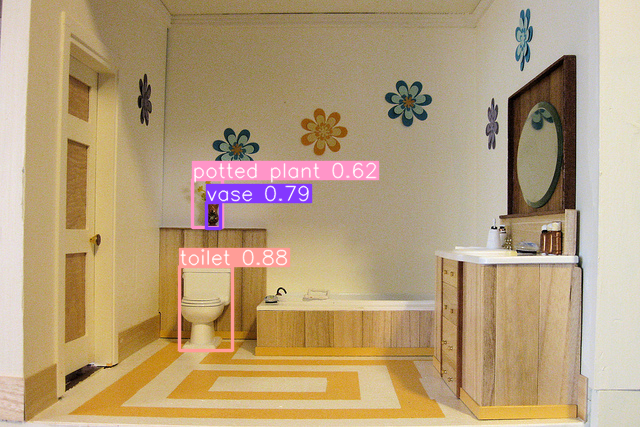

In [ ]:
Image.fromarray(results[0].plot()[:, :, ::-1])

In [ ]:
IMAGE_PATH = Path("/content/gdrive/bus.jpg")

In [ ]:
results = model(IMAGE_PATH)


image 1/1 /content/gdrive/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 15.2ms
Speed: 4.9ms preprocess, 15.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


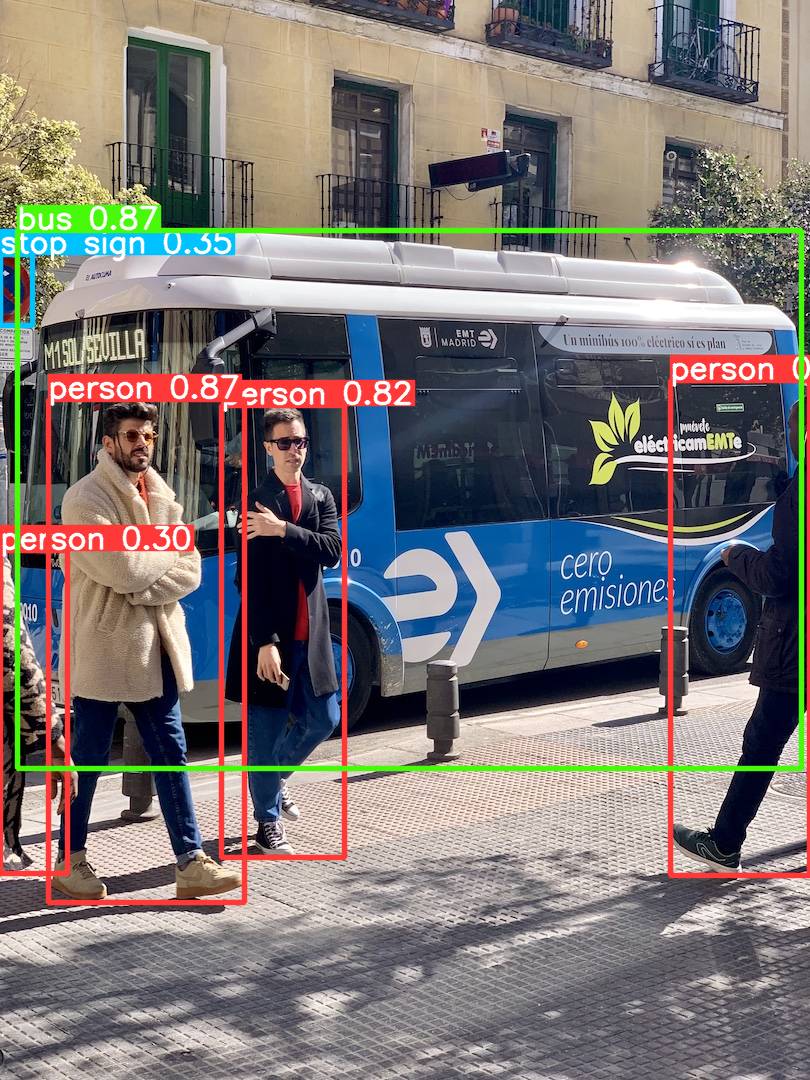

In [ ]:
Image.fromarray(results[0].plot()[:, :, ::-1])